# Rockall Trough transport

In [1]:
%load_ext autoreload
%autoreload 2
import sys; sys.path.append(r'../') # Add this line at the beginner of each notebook to be able to load local functions 
import src.features.RT_functions as rtf
import src.features.RT_data as rtd
import src.features.matfile_functions as matlab_fct
import src.features.RT_EOF_functions as rt_eof

In [2]:
import dask
import datetime
import gsw
import scipy
import scipy.io
import cmocean as cm
import numpy as np
import pandas as pd
import seawater as sw
import scipy.signal as signal
import palettable.colorbrewer as cb
import xarray as xr
from pathlib import Path
from scipy.signal import butter, filtfilt
from xhistogram.xarray import histogram as xhist
%matplotlib inline
from matplotlib import pyplot as plt

### Set in- and output path

In [3]:
date_str_start = '201407'
date_str_end = '202207'
fn_version = 'v1'
script_name = f"3.0_Rockall_Trough_transports_{date_str_start[:-2]}_{date_str_end[:-2]}_v1"

# output figures
fig_out_path = f"C:/Users/sa07kb/Projects/Rockall_Trough_Transports/figures/{script_name}/"
Path(fig_out_path).mkdir(parents=True, exist_ok=True)

In [4]:
# output data
data_out_path = f"C:/Users/sa07kb/Projects/Rockall_Trough_Transports/data/{script_name}/"
Path(data_out_path).mkdir(parents=True, exist_ok=True)

fn_base = "Rockall_Trough_transport_time_series"
file_name_out = f"{fn_base}_{date_str_start}_{date_str_end}_{fn_version}.nc"

In [5]:
# intput data
global_data_path = Path("C:/Users/sa07kb/OneDrive - SAMS/data/")
raw_data_path = Path('../data/raw')
local_data_path = Path('../data/0.0_Rockall_Trough_moorings_data_prep_2014_2022_v0/')
local_data_path_v0 = Path('../data/1.0_Rockall_Trough_transports_2014_2022_v0/')

# file directories
GEBCO_data_path = (global_data_path/ 'data_GEBCO')
GLORYS_data_path = (global_data_path/ 'data_GLORYS')
RT_mooring_data_path = local_data_path
ERA5_data_path = (global_data_path/ 'data_ERA5/Rockall_Trough')
glider_data_path = (global_data_path/ 'data_seaglider')

# file names
RT_mooring_fn = f'Rockall_Trough_mooring_gridded_TSUV_{date_str_start}_{date_str_end}_v0.1.nc'
RT_mooring_loc = 'Ellet_array_mooring_location.csv'
glider_fn = 'glider_sections_gridded.mat'
GEBCO_fn = 'GEBCO_2014_2D_-22.0_55.0_-7.0_59.0.nc'
GLORYS_fn_re = list(sorted(
        (GLORYS_data_path).glob(f"*reanalyis-phy*Vvel.nc") # reanalysis
    ))
GLORYS_fn_an = list(sorted(
        (GLORYS_data_path).glob(f"*anfc-phy-001_024_Vvel.nc") # analysis/forecasts
    ))
ERA5_fn = 'ERA5_tauxy_RT_2014-2022.nc' 

## Parameter Preamble

In [6]:
filter_length = 90     # (days)
corr_model = 0.0759    # Correction parameter (m/s) to adjust GLORYS DAC V component to the 8 month DAC from ADCP
z_cutoff_EW = 750     # Depth (m) where transition from GLORYS-ADCP data to CM data at Eastern wedge
z_cutoff_WW = 250     # Depth (m) limit of upper-left corner cutout
lon_cutoff_WW = -12.906  # Longitude limit of upper-left corner cutout
NX_WW = 100            # Horizontal grid size in Western wedge
NX_MB = 100           # Horizontal grid size in Mid-basin (needed for Ekman calc.)
NX_EW = 100            # Horizontal grid size in Eastern wedge
SA_ref = 35.34         # Reference Absolute Salinity (g/kg), for freshwater flux calc
CT_ref = 7.07          # Reference Conservative Temperature (C), for heat flux calc
rhoCp = 4.1e6         # Constant: Reference density times specific heat capacity (J m^-3 C^-1)   
rho0 = 1027            # Reference density          
Omega = 7.2921e-5     # Earth's rotation

## Load Data and prepare for calculations

In [7]:
# Rockall Trough mooring location
moor_ds=pd.read_csv(raw_data_path/RT_mooring_loc)
moor_ds = moor_ds.set_index(['ID']).to_xarray()

lon_RTWB1 = moor_ds.sel(ID='RTWB1').lon.values
lat_RTWB1 = moor_ds.sel(ID='RTWB1').lat.values
lon_RTWB2 = moor_ds.sel(ID='RTWB2').lon.values
lat_RTWB2 = moor_ds.sel(ID='RTWB2').lat.values
lon_RTWB = (lon_RTWB1 + lon_RTWB2)/2
lat_RTWB = (lat_RTWB1 + lat_RTWB2)/2
lon_RTEB = moor_ds.sel(ID='RTEB1').lon.values
lat_RTEB = moor_ds.sel(ID='RTEB1').lat.values
lon_RTADCP = moor_ds.sel(ID='RTADCP').lon.values
lat_RTADCP = moor_ds.sel(ID='RTADCP').lat.values
lon_RTWS = moor_ds.sel(ID='RTWS').lon.values
lat_RTWS = lat_RTWB
lon_RTES = moor_ds.sel(ID='RTES').lon.values
lat_RTES = lat_RTEB

In [8]:
# gridded Rockall Trough mooring data
ds_RT = xr.open_dataset((RT_mooring_data_path/RT_mooring_fn))

#remove nan at beginning and end
ds_RT = ds_RT.where(ds_RT.TG_EAST.sel(PRES=500).notnull().drop_vars('PRES'),drop=True)

In [9]:
#linearly interpolate over time gaps in velocity fields
ds_RT = ds_RT.interpolate_na(dim='TIME')

# Get z from P
ds_RT.coords['depth'] = gsw.z_from_p(ds_RT.PRES,np.mean([lat_RTWB, lat_RTEB]))
ds_RT.depth.attrs = {'name' :'depth',
                     'units' :'m',}

# Create merged WB1/2 CM
ds_RT['v_RTWB'] = ds_RT.V_WEST_2.where(ds_RT.V_WEST_1.isnull())
ds_RT['v_mask'] = (ds_RT.v_RTWB.notnull()+ds_RT.V_WEST_1.notnull())
ds_RT['v_RTWB'] = (ds_RT.v_RTWB.fillna(0)+ds_RT.V_WEST_1.fillna(0)).where(ds_RT.v_mask==1)


# Load  GEBCO bathymetry
ds_GEBCO = xr.open_dataset((GEBCO_data_path/GEBCO_fn))
ds_GEBCO = ds_GEBCO.where(ds_GEBCO.elevation<=0)

# load GLORYS model data
ds_GLORYS_re = xr.open_mfdataset(GLORYS_fn_re)
ds_GLORYS_an = xr.open_mfdataset(GLORYS_fn_an)
ds_GLORYS_an.coords['latitude'] = ds_GLORYS_re.latitude # lat and lon slightly different values, i.e. manually merge
ds_GLORYS_an.coords['longitude'] = ds_GLORYS_re.longitude
ds_GLORYS_an.coords['depth'] = ds_GLORYS_re.depth
ds_GLORYS = xr.concat([ds_GLORYS_re,ds_GLORYS_an],'time')

# load ERA5
ds_ERA5 = xr.open_dataset((ERA5_data_path/ERA5_fn))
ds_ERA5 = ds_ERA5.sel(expver=1).combine_first(ds_ERA5.sel(expver=5))

In [10]:
#load glider
ds_glider = matlab_fct.load_glider_mat(glider_data_path,glider_fn)
ds_glider_nan = rt_eof.add_nan_glider_sections(ds_glider)

In [11]:
ds_RT = rtf.ds_rt_swap_vert_dim(ds_RT)

# Calculations

## Horizontal and vertical grid parameters

In [12]:
# def create_grid(x_w,x_e,NX,dim)

lon_WW = xr.DataArray(np.linspace(lon_RTWS,lon_RTWB,NX_WW),dims='lon_WW')
lon_MB = xr.DataArray(np.linspace(lon_RTWB,lon_RTEB,NX_MB),dims='lon_MB')
lon_EW = xr.DataArray(ds_glider.lon.values,dims='lon_EW')
lat_WW = xr.DataArray(np.linspace(lat_RTWS,lat_RTWB,NX_WW),dims='lon_WW')
lat_MB = xr.DataArray(np.linspace(lat_RTWB,lat_RTEB,NX_MB),dims='lon_MB')
lat_EW = xr.DataArray(ds_glider.lat.values,dims='lon_EW')

lon_WW.coords['lon_WW']=lon_WW.values
lat_WW.coords['lon_WW']=lon_WW.values

lon_MB.coords['lon_MB']=lon_MB.values
lat_MB.coords['lon_MB']=lon_MB.values

lon_EW.coords['lon_EW']=lon_EW.values
lat_EW.coords['lon_EW']=lon_EW.values

In [13]:
#Get dx
dx_EW = rtf.get_dx(lon_EW,lat_EW,dim='lon_EW')
dx_MB = xr.apply_ufunc(
            gsw.distance,
            lon_MB,lat_MB,
            input_core_dims=[['lon_MB'],['lon_MB']],
            output_core_dims=[['lon_MB']],
            exclude_dims=set(('lon_MB',)), 
    )
dx_WW = rtf.get_dx(lon_WW,lat_WW,dim='lon_WW')

In [14]:
# Get x
x_WW = np.linspace(0,(NX_WW-1)*dx_WW,NX_WW).squeeze()
x_MB = np.linspace(0,(NX_MB-1)*dx_MB,NX_MB-1).squeeze()
x_EW = np.linspace(0,(NX_EW-1)*dx_EW,NX_EW).squeeze()

In [15]:
# Get dz (top/bottom cells are ~10m thick, cells are ~20m thick elsewhere)
dz = rtf.get_dz(ds_RT.depth)
ds_RT['dz']=xr.DataArray(dz,dims='depth')

In [16]:
# Get section bathymetry
bathy_WW = ds_GEBCO.elevation.interp(lon=lon_WW, lat=lat_WW).drop(['lon','lat'])
bathy_WW.coords['lon_WW']=lon_WW
bathy_EW = ds_GEBCO.elevation.interp(lon=lon_EW, lat=lat_EW).drop(['lon','lat'])
bathy_EW.coords['lon_EW']=lon_EW

In [17]:
ds_RT

<xarray.Dataset>
Dimensions:   (TIME: 5827, depth: 101)
Coordinates:
  * TIME      (TIME) datetime64[ns] 2014-07-21T12:00:00 ... 2022-07-12T12:00:00
    PRES      (depth) float64 0.0 20.19 40.38 60.57 ... 1.988e+03 nan nan
  * depth     (depth) float32 0.0 20.0 40.0 60.0 ... 1.96e+03 1.98e+03 2e+03
Data variables: (12/16)
    TG_EAST   (TIME, depth) float64 10.27 10.27 10.27 10.27 ... nan nan nan nan
    TG_WEST   (TIME, depth) float64 10.22 10.22 10.22 10.22 ... nan nan nan nan
    SG_EAST   (TIME, depth) float64 35.57 35.57 35.57 35.57 ... nan nan nan nan
    SG_WEST   (TIME, depth) float64 35.56 35.56 35.56 35.56 ... nan nan nan nan
    U_WEST_1  (TIME, depth) float64 -6.113 -6.012 -5.91 -5.808 ... nan nan nan
    V_WEST_1  (TIME, depth) float64 -1.635 -1.867 -2.099 -2.331 ... nan nan nan
    ...        ...
    U_EAST    (TIME, depth) float64 -1.015 -1.004 -0.993 -0.982 ... nan nan nan
    V_EAST    (TIME, depth) float64 -7.281 -7.315 -7.349 -7.383 ... nan nan nan
    W_EAST    (TIME, depth) float64 -0.05297 -0.03409 -0.01522 ... nan nan nan
    v_RTWB    (TIME, depth) float64 -1.635 -1.867 -2.099 -2.331 ... nan nan nan
    v_mask    (TIME, depth) bool True True True True ... False False False False
    dz        (depth) float32 10.0 20.0 20.0 20.0 20.0 ... 20.0 20.0 20.0 10.0
Attributes: (12/26)
    title:                         CLASS Rockall Trough mooring data Jul 2014...
    institution:                   Scottish Association for Marine Science, S...
    history:                       Delayed time processed quality controlled ...
    id:                            Rockall_Trough_mooring_gridded_TSUV_201407...
    source:                        subsurface mooring
    project:                       Climate Linked Atlantic Sector Science
    ...                            ...
    date_created:                  2023-12-13T23:18:29Z
    date_modified:                 12-01-2024T15:58:36Z
    processing_level:              
    QC_indicator:                  
    contributor_name:              Kristin Burmeister
    contributor_email:             Kristin.Burmeister@sams.ac.uk

## Midbasin transport based on no motion at 1760 dbar

In [18]:
# Get Coriolis freq
f = gsw.f(np.mean([lat_RTWB,lat_RTEB]))

# Get reference pressure
P_ref = ds_RT.where((ds_RT.SG_WEST+ds_RT.SG_EAST).notnull(),drop=True).PRES.max().values

# # Calculate baroclinic streamfunction
SF_RTWB = rtf.gsw_geo_strf_dyn_height(ds_RT.SG_WEST,ds_RT.TG_WEST,ds_RT.PRES,P_ref)
SF_RTEB = rtf.gsw_geo_strf_dyn_height(ds_RT.SG_EAST,ds_RT.TG_EAST,ds_RT.PRES,P_ref)

# Calculate geostrophic transport (Sv) in each cell as function of (z,t)
q_MB = ds_RT.dz*((SF_RTEB - SF_RTWB)/f)
q_MB.coords['lat_MB']=np.mean([lat_RTWB,lat_RTEB])
q_MB.coords['lon_MB']=np.mean([lon_RTWB,lon_RTEB])

# Perform vertical integral for timeseries (Sv)
Q_MB = q_MB.sum(['depth'],min_count=1)/1e6

Q_MB.attrs['name']= 'RT_Q_MB'
Q_MB.attrs['long_name']= 'RT MB Volume Transport'
Q_MB.attrs['units']='Sv'
Q_MB.attrs['description']='Mid basin volume transport in Rockall Trough'\
' derived from dynamic height difference between the moorings RTEB1 and RTWB1+2'

## Some sensitivity analysis - extra

# Calculate temporal mean over entire timeseries and broadcast over TIME dimension
(ds_RT_ave,_) = xr.broadcast(ds_RT.mean('TIME'),ds_RT.TIME)

# % Do it again isolating SA changes/ keeping CT fixed
SF_RTWB_CTfix = rtf.gsw_geo_strf_dyn_height(ds_RT.SG_WEST,ds_RT_ave.TG_WEST,ds_RT.PRES,P_ref)
SF_RTEB_CTfix = rtf.gsw_geo_strf_dyn_height(ds_RT.SG_EAST,ds_RT_ave.TG_EAST,ds_RT.PRES,P_ref)
q_MB_CTfix = ds_RT.dz*((SF_RTEB_CTfix - SF_RTWB_CTfix)/f)
Q_MB_CTfix = q_MB_CTfix.sum('depth',min_count=1)/1e6
Q_MB_CTfix.attrs['name']= 'RT_Q_MB_CTfix'
Q_MB_CTfix.attrs['long_name']= 'RT MB Volume Transport CT fixed'
Q_MB_CTfix.attrs['units']='Sv'
Q_MB_CTfix.attrs['description']='As Q_MB but holding temperature fixed at temporal mean at all moorings'

# % Do it again isolating CT changes / keeping SA fixed
SF_RTWB_SAfix = rtf.gsw_geo_strf_dyn_height(ds_RT_ave.SG_WEST,ds_RT.TG_WEST,ds_RT.PRES,P_ref)
SF_RTEB_SAfix = rtf.gsw_geo_strf_dyn_height(ds_RT_ave.SG_EAST,ds_RT.TG_EAST,ds_RT.PRES,P_ref)
q_MB_SAfix = ds_RT.dz*((SF_RTEB_SAfix - SF_RTWB_SAfix)/f)
Q_MB_SAfix = q_MB_SAfix.sum('depth',min_count=1)/1e6
Q_MB_SAfix.attrs['name']= 'RT_Q_MB_SAfix'
Q_MB_SAfix.attrs['long_name']= 'RT MB Volume Transport SA fixed'
Q_MB_SAfix.attrs['units']='Sv'
Q_MB_SAfix.attrs['description']= 'As Q_MB but holding salinity fixed at temporal mean at all moorings'

# % Do it again holding both fixed
SF_RTWB_SAfix_CTfix = rtf.gsw_geo_strf_dyn_height(ds_RT_ave.SG_WEST,ds_RT_ave.TG_WEST,ds_RT.PRES,P_ref)
SF_RTEB_SAfix_CTfix = rtf.gsw_geo_strf_dyn_height(ds_RT_ave.SG_EAST,ds_RT_ave.TG_EAST,ds_RT.PRES,P_ref)
q_MB_SAfix_CTfix = ds_RT.dz*((SF_RTEB_SAfix_CTfix - SF_RTWB_SAfix_CTfix)/f)
Q_MB_SAfix_CTfix = q_MB_SAfix_CTfix.sum('depth',min_count=1)/1e6
Q_MB_SAfix_CTfix.attrs['name']= 'RT_Q_MB_SAfix_CTfix'
Q_MB_SAfix_CTfix.attrs['long_name']= 'RT MB Volume Transport SA and CT fixed'
Q_MB_SAfix_CTfix.attrs['units']='Sv'
Q_MB_SAfix_CTfix.attrs['description']= 'As Q_MB but holding temperature and salinity fixed at temporal mean at all moorings'

# % Do it again isolating CT_RTWB
q_MB_WB_CTvar = ds_RT.dz*((SF_RTEB_SAfix_CTfix - SF_RTWB_SAfix)/f)
Q_MB_WB_CTvar = q_MB_WB_CTvar.sum('depth',min_count=1)/1e6
Q_MB_WB_CTvar.attrs['name']= 'RT_Q_MB_WB_CTvar'
Q_MB_WB_CTvar.attrs['long_name']= 'RT MB Volume Transport isolating CT changes at RTWB'
Q_MB_WB_CTvar.attrs['units']='Sv'
Q_MB_WB_CTvar.attrs['description']= 'As Q_MB but isolating temperature changes at RTWB'\
                        ' and holding temperature at RTEB and salinity at RTWB & RTEB'\
                        ' fixed at temporal mean'

# % Do it again isolating CT_RTEB
q_MB_EB_CTvar = ds_RT.dz*((SF_RTEB_SAfix - SF_RTWB_SAfix_CTfix)/f)
Q_MB_EB_CTvar = q_MB_EB_CTvar.sum('depth',min_count=1)/1e6
Q_MB_EB_CTvar.attrs['name']= 'RT_Q_MB_EB_CTvar'
Q_MB_EB_CTvar.attrs['long_name']= 'RT MB Volume Transport isolating CT changes at RTEB'
Q_MB_EB_CTvar.attrs['units']='Sv'
Q_MB_EB_CTvar.attrs['description']= 'As Q_MB but isolating temperature changes at RTEB'\
                    ' and holding temperature at RTWB and salinity at RTWB & RTEB'\
                    ' fixed at temporal mean'

# Merge to dataset
RT_Q_MB = xr.merge([Q_MB.rename(Q_MB.attrs['name']),
                Q_MB_SAfix.rename(Q_MB_SAfix.attrs['name']),
                Q_MB_CTfix.rename(Q_MB_CTfix.attrs['name']),
                Q_MB_SAfix_CTfix.rename(Q_MB_SAfix_CTfix.attrs['name']),
                Q_MB_WB_CTvar.rename(Q_MB_WB_CTvar.attrs['name']),
                Q_MB_EB_CTvar.rename(Q_MB_EB_CTvar.attrs['name'])])

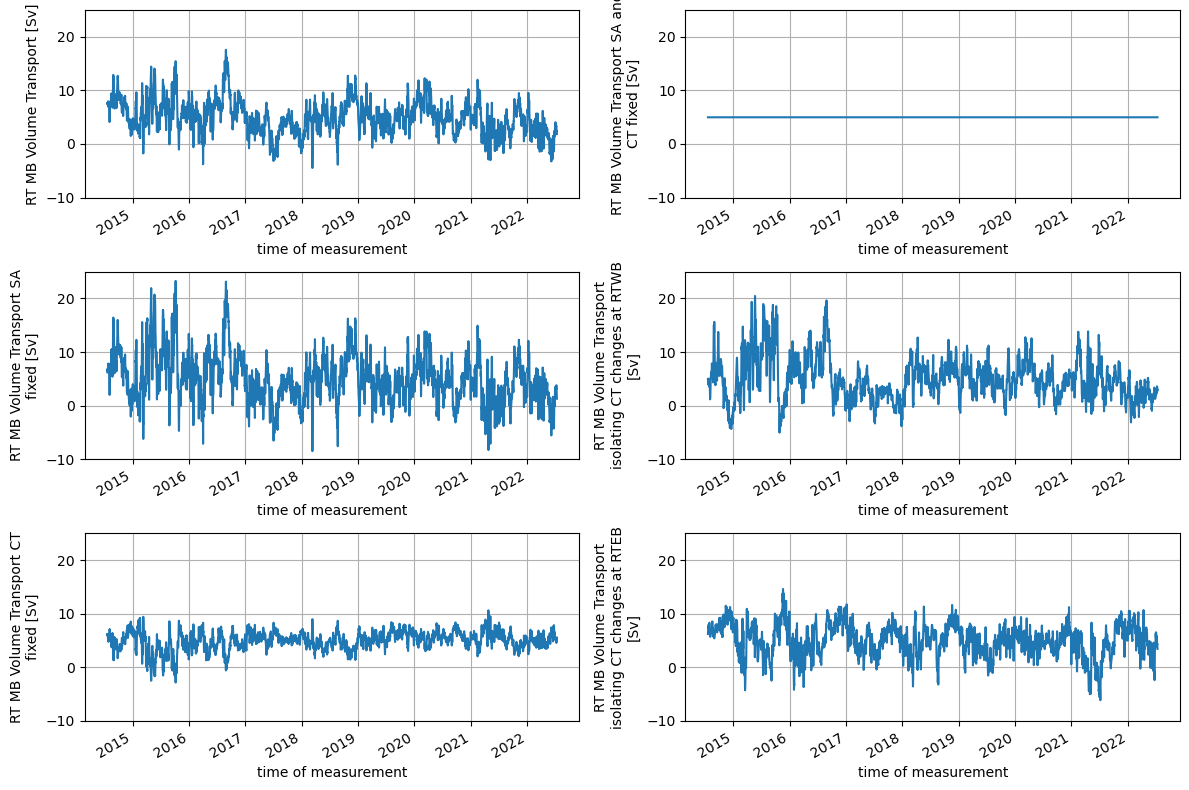

In [19]:
fig,axs=plt.subplots(3,2,figsize=[12,8])
ax = axs[0,0]
RT_Q_MB.RT_Q_MB.plot(ax=ax)
ax = axs[1,0]
RT_Q_MB.RT_Q_MB_SAfix.plot(ax=ax)
ax = axs[2,0]
RT_Q_MB.RT_Q_MB_CTfix.plot(ax=ax)
ax = axs[0,1]
RT_Q_MB.RT_Q_MB_SAfix_CTfix.plot(ax=ax)
ax = axs[1,1]
RT_Q_MB.RT_Q_MB_WB_CTvar.plot(ax=ax)
ax = axs[2,1]
RT_Q_MB.RT_Q_MB_EB_CTvar.plot(ax=ax)
for ax in axs.flat:
    ax.grid()
    ax.set_ylim([-10,25])
    ax.set_title('')
fig.tight_layout()

In [20]:
# # create MB matrix, fine horizontal grid, new and not in Fraser et al. (2022)
SG_MB_grid = xr.concat([ds_RT.SG_WEST.expand_dims('lon_MB'),
          ds_RT.SG_EAST.expand_dims('lon_MB')],dim='lon_MB')
SG_MB_grid['lon_MB']=[lon_RTWB,lon_RTEB]
SG_MB_grid.coords['lat_MB']= ('lon_MB',[lat_RTWB,lat_RTEB])

TG_MB_grid = xr.concat([ds_RT.TG_WEST.expand_dims('lon_MB'),
          ds_RT.TG_EAST.expand_dims('lon_MB')],dim='lon_MB')
TG_MB_grid['lon_MB']=[lon_RTWB,lon_RTEB]
TG_MB_grid.coords['lat_MB']= ('lon_MB',[lat_RTWB,lat_RTEB])

SG_MB_grid = SG_MB_grid.interp(lon_MB=lon_MB)
TG_MB_grid = TG_MB_grid.interp(lon_MB=lon_MB)

# Calculate baroclinic streamfunction
SF_MB_grid = xr.apply_ufunc(
        gsw.geo_strf_dyn_height,
        SG_MB_grid,TG_MB_grid,TG_MB_grid.PRES,P_ref,
        kwargs={'axis':2},
        input_core_dims=[['lon_MB', 'TIME', 'depth'],['lon_MB', 'TIME', 'depth'],['depth'],[]],
        output_core_dims=[['lon_MB', 'TIME', 'depth']],
        dask = 'parallelized')

# Calculate geostrophic transport (Sv) in each cell as function of (z,t)
q_MB_grid = dz*(SF_MB_grid.diff('lon_MB')/f)
lon_MB = xr.DataArray(((SF_MB_grid.lon_MB[:-1].values+SF_MB_grid.lon_MB[1:].values)/2),dims='lon_MB')
q_MB_grid['lon_MB']=lon_MB
lat_MB = xr.DataArray(((SF_MB_grid.lat_MB[:-1].values+SF_MB_grid.lat_MB[1:].values)/2),dims='lon_MB')
q_MB_grid.coords['lat_MB']= lat_MB
q_MB_grid['dx_MB'] = dx_MB

ds_RT_MB_grid = xr.merge([q_MB_grid.rename('q'),
                      TG_MB_grid.rename('CT').drop('lat_MB').interp(lon_MB=q_MB_grid.lon_MB),
                      SG_MB_grid.rename('SA').drop('lat_MB').interp(lon_MB=q_MB_grid.lon_MB)])

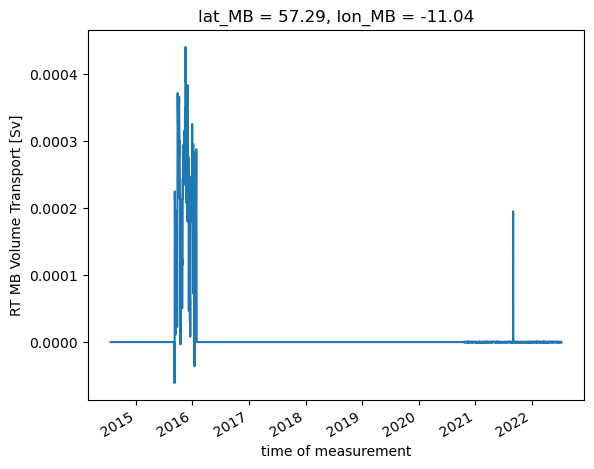

In [21]:
(RT_Q_MB.RT_Q_MB-(q_MB_grid.sum(['depth','lon_MB'],min_count=1)/1e6)).plot()

## Western wedge transport

In [22]:
# Constant value east of WB1
v_WW = ds_RT.v_RTWB.rename('v_WW').compute()
(v_WW,_) = xr.broadcast(v_WW,xr.DataArray(lon_WW, dims="lon_WW"))
v_WW.coords['lon_WW']=lon_WW
v_WW.coords['lat_WW']=lat_WW
v_WW = v_WW.where(lon_WW>=lon_RTWB1)

# Upper 250 m: Linear decay from WB1 value to 0, western limit is cut off lon
i_bathy = (lon_WW<lon_RTWB1) & (lon_WW>=lon_cutoff_WW)
y = xr.apply_ufunc(
    np.linspace,
    0,ds_RT.v_RTWB.where((ds_RT.depth<z_cutoff_WW)),sum(i_bathy),
    input_core_dims=[[],['depth','TIME'],[]],
    output_core_dims=[['lon_WW','depth','TIME']],
    dask='parallelized')

y.coords['lon_WW']= lon_WW[(lon_WW<lon_RTWB1) & (lon_WW>=lon_cutoff_WW)]

(v_WW,y)=xr.broadcast(v_WW,y)
mask = (v_WW.notnull()+y.notnull())
v_WW = (v_WW.fillna(0)+y.fillna(0)).where(mask)

# Below 250 m: Linear decay from WB1 value to 0, western limit is bathymetry
i_bathy =(-1*bathy_WW.where(lon_WW<lon_RTWB1)>ds_RT.depth.where(ds_RT.depth>z_cutoff_WW))

for idx,bathy in enumerate(i_bathy.sum('lon_WW')):
    if bathy>0:
        y1 = xr.apply_ufunc(
        np.linspace,
        0,ds_RT.v_RTWB.isel(depth=[idx]),bathy,
        input_core_dims=[[],['TIME','depth'],[]],
        output_core_dims=[['lon_WW','TIME','depth']], 
        dask='parallelized')
        
        y1.coords['lon_WW']= lon_WW.values[i_bathy[:,idx]]
        (_,y1)=xr.broadcast(v_WW,y1)
        mask = (v_WW.notnull()+y1.notnull())
        v_WW = (v_WW.fillna(0)+y1.fillna(0)).where(mask)
v_WW = v_WW.fillna(0).where(v_WW.depth<-1*bathy_WW)

# Transport in each cell
q_WW = dx_WW*ds_RT.dz*(v_WW/1e2)

# Integrate for transport timeseries (Sv)
Q_WW = q_WW.sum(['depth','lon_WW'],min_count=1)/1e6 
Q_WW.coords['mask_WW'] = ds_RT.v_RTWB.isel(depth=50).notnull()
Q_WW.attrs['name']= 'RT_Q_WW'
Q_WW.attrs['long_name']= 'RT WW Volume Transport'
Q_WW.attrs['units']='Sv'
Q_WW.attrs['description']='Volume transport at western wedge of Rockall Trough'\
' derived from moored velocity measurements at RTWB1+2'

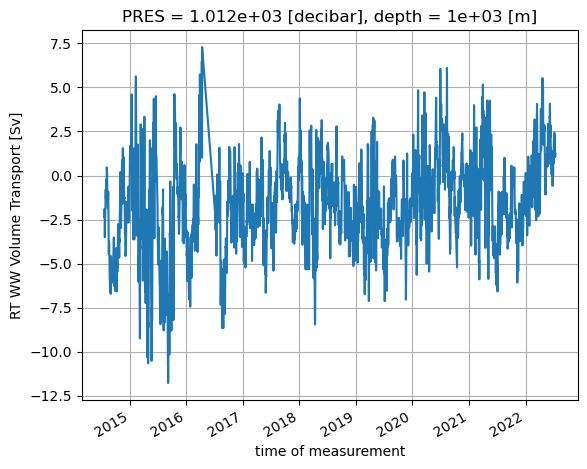

In [23]:
Q_WW.where(Q_WW.mask_WW).plot()
plt.grid()

## Eastern wedge

In [24]:
# Calculate glider EOF
v_anomaly = ds_glider.vcur.resample(time="15D").mean()
v_anomaly = v_anomaly - v_anomaly.mean('time',keep_attrs=True)

glider_EOF = rt_eof.EOF_func(v_anomaly,n_modes=1,plot_out=False,dim='lon')

In [25]:
# Create y from moored velocity data for linear regression (X'X*alpha=X'y)
#get mean glider section at mooring positions
glider_locs = ds_glider.vcur.sel(lon=[lon_RTEB,lon_RTADCP],method='nearest').mean('time').compute()
glider_locs['depth']=np.abs(glider_locs.depth)

# Get RTEB1 meridional velocity
v_RTEB1=(ds_RT.V_EAST/1e2).interp(depth=('depth',glider_locs.depth.data)).rename({'TIME':'time'}).drop('PRES')

# Get Glorys data at ADCP station and apply corretions
v_GLO_RTADCP = ds_GLORYS.vo.interp(longitude=glider_locs.lon.sel(lon=[lon_RTADCP],method='nearest').data,
                    latitude=lat_RTADCP,
                    time=('time',v_RTEB1.time.data),
                    depth=('depth',glider_locs.depth.data)) + corr_model

# Duplicate top GLORYS-ADCP values
mask = v_GLO_RTADCP
mask = (mask.notnull()+mask.shift(depth=-1).notnull())
v_GLO_RTADCP = v_GLO_RTADCP.interpolate_na(dim="depth", method="nearest", fill_value="extrapolate")
v_GLO_RTADCP = v_GLO_RTADCP.where(mask).rename({'longitude':'lon'})

# combinde both to one matrix (time,depth,lon)
ds_y = xr.concat([v_RTEB1,v_GLO_RTADCP.drop_vars(['latitude','lon'])], dim="lon")
ds_y['lon']=glider_locs.lon.data

# Remove glider sections temporal mean from y
ds_y = (ds_y-glider_locs).compute()

# get EOF components at mooring positions as X for linear regression (X'X*alpha=X'y)
# initial X matrix (mode,lon,depth)
ds_X = glider_EOF.components().sel(lon=[lon_RTEB,lon_RTADCP],method='nearest').compute()

# get alpha & reconstruct velocity fields
v_rec = rt_eof.rec_v_sec(ds_X,ds_y,glider_EOF,ds_glider.vcur)
v_rec = v_rec.rename({'time':'TIME','lon':'lon_EW'})
v_rec['depth']=abs(v_rec.depth)
v_rec = v_rec.interp_like(ds_RT.depth)

zlim = v_rec.depth.where(v_rec.notnull()).max()

(v_EW,_) = xr.broadcast(ds_RT.V_EAST/100,v_rec.lon_EW)
mask = v_EW.notnull()

v_EW = v_rec.fillna(0)+v_EW.where(v_EW.depth>zlim).fillna(0)
v_EW = v_EW.where(mask)

# Mask bathy
v_EW = v_EW.where(v_EW.depth<-1*bathy_EW)


# Transport in each cell
q_EW = dx_EW*ds_RT.dz*(v_EW)

# Integrate for transport timeseries (Sv)
Q_EW = q_EW.sum(['depth','lon_EW'],min_count=1)/1e6
Q_EW.coords['mask_EW'] = ds_RT.V_WEST_1.isel(depth=50).notnull()
Q_EW.attrs['name']= 'RT_Q_EW'
Q_EW.attrs['long_name']= 'RT EW Volume Transport'
Q_EW.attrs['units']='Sv'
Q_EW.attrs['description']='Volume transport at eastern wedge of Rockall Trough'\
' derived from moored velocity measurements at RTEB1'

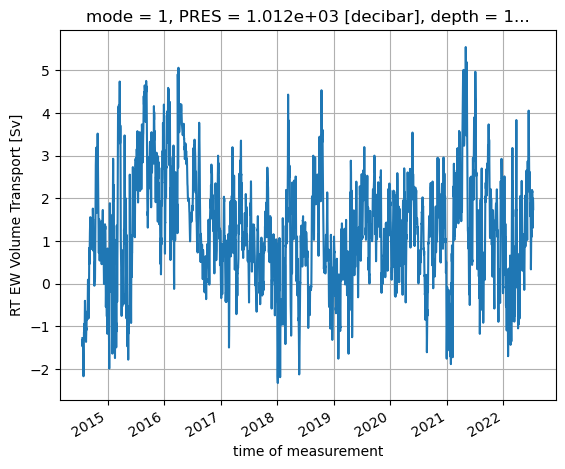

In [26]:
Q_EW.where(Q_EW.mask_EW).plot()
plt.grid()

## Ekman transport

In [27]:
ds_ERA_MB = ds_ERA5[['metss','mntss']].interp(longitude=lon_MB, latitude=lat_MB).drop(['longitude','latitude'])
ds_ERA_MB.coords['lon_MB']=lon_MB
ds_ERA_WW = ds_ERA5[['metss','mntss']].interp(longitude=lon_WW, latitude=lat_WW).drop(['longitude','latitude'])
ds_ERA_WW.coords['lon_WW']=lon_WW
ds_ERA_EW = ds_ERA5[['metss','mntss']].interp(longitude=lon_EW, latitude= lat_EW).drop(['longitude','latitude'])
ds_ERA_EW.coords['lon_EW']=lon_EW

# Get normal and tangent to each section
def tau_rot(ds,lat,lon):
    (_,pa) = np.radians(sw.dist(lat[:2],lon[:2],'km'))
    tau_rot = np.cos(pa)*ds.metss + np.sin(pa)*ds.mntss
    return tau_rot

# Get tau tangent to section
tau_para_MB = tau_rot(ds_ERA_MB,lat_MB,lon_MB)
tau_para_WW = tau_rot(ds_ERA_WW,lat_WW,lon_WW)
tau_para_EW = tau_rot(ds_ERA_EW,lat_EW,lon_EW)

# Get Ekman
f = 2*Omega*np.sin(np.radians(lat_RTWB))
V_Ek_WW = -1*tau_para_WW/(f*rho0)
V_Ek_MB = -1*tau_para_MB/(f*rho0)
V_Ek_EW = -1*tau_para_EW/(f*rho0)

# Transport per cell in Sv
q_Ek_WW = V_Ek_WW*dx_WW/1e6
q_Ek_MB = V_Ek_MB*dx_MB/1e6
q_Ek_EW = V_Ek_EW*dx_EW/1e6

# Integrate transport timeseries
Q_Ek_WW = q_Ek_WW.sum('lon_WW')
Q_Ek_WW.attrs['name']= 'Q_Ek_WW'
Q_Ek_WW.attrs['long_name']= 'RT WW Ekman Transport'
Q_Ek_WW.attrs['units']='Sv'
Q_Ek_WW.attrs['description']= 'Ekman Transport at wester wedge of Rockall Trough'\
' derived from ERA5 monthly data'

Q_Ek_MB = q_Ek_MB.sum('lon_MB')
Q_Ek_MB.attrs['name']= 'Q_Ek_MB'
Q_Ek_MB.attrs['long_name']= 'RT MB Ekman Transport'
Q_Ek_MB.attrs['units']='Sv'
Q_Ek_MB.attrs['description']= 'Ekman Transport across Rockall Trough'\
' derived from ERA5 monthly data'

Q_Ek_EW = q_Ek_EW.sum('lon_EW')
Q_Ek_EW.attrs['name']= 'Q_Ek_EW'
Q_Ek_EW.attrs['long_name']= 'RT EW Ekman Transport'
Q_Ek_EW.attrs['units']='Sv'
Q_Ek_EW.attrs['description']= 'Ekman Transport at eastern wedge of Rockall Trough'\
' derived from ERA5 monthly data'

# Merge to dataset
RT_Q_Ek = xr.merge([Q_Ek_WW.rename(Q_Ek_WW.attrs['name']),
                Q_Ek_MB.rename(Q_Ek_MB.attrs['name']),
                Q_Ek_EW.rename(Q_Ek_EW.attrs['name'])])

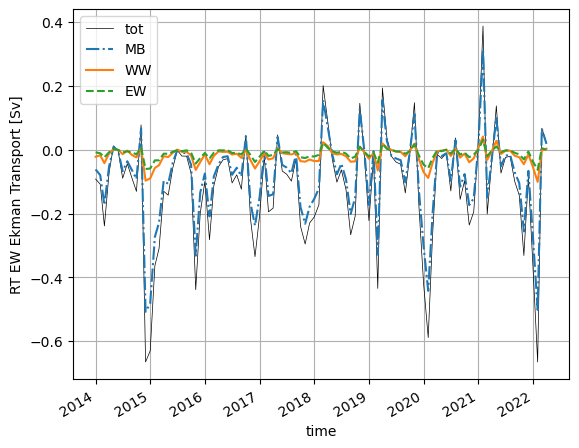

In [28]:
(RT_Q_Ek.Q_Ek_WW+RT_Q_Ek.Q_Ek_MB+RT_Q_Ek.Q_Ek_EW).plot(lw=.5,color='k',label='tot')
RT_Q_Ek.Q_Ek_MB.plot.line(ls='-.',label='MB')
RT_Q_Ek.Q_Ek_WW.plot.line(ls='-',label='WW')
RT_Q_Ek.Q_Ek_EW.plot.line(ls='--',label='EW')
plt.grid()
plt.legend()

## Heat and Freshwater Fluxes

In [29]:
# Get SA and CT fields - interpolate for midbasin
ds_RT['SG_MB'] = (ds_RT.SG_WEST + ds_RT.SG_EAST)/2
ds_RT['TG_MB'] = (ds_RT.TG_WEST + ds_RT.TG_EAST)/2

# Compute fluxes in each cell
qh_EW = rhoCp*q_EW*(ds_RT.TG_EAST - CT_ref)
qh_MB = rhoCp*q_MB*(ds_RT.TG_MB - CT_ref)
qh_WW = rhoCp*q_WW*(ds_RT.TG_WEST - CT_ref)
qf_EW = -1*q_EW*(ds_RT.SG_EAST - SA_ref)/SA_ref
qf_MB = -1*q_MB*(ds_RT.SG_MB - SA_ref)/SA_ref;
qf_WW = -1*q_WW*(ds_RT.SG_WEST - SA_ref)/SA_ref
qS_EW = q_EW*ds_RT.SG_EAST/1027.4
qS_MB = q_MB*ds_RT.SG_MB/1027.4;
qS_WW = q_WW*ds_RT.SG_WEST/1027.4

# % Integrate for timeseries (PW and Sv)
Qh_WW = qh_WW.sum(['depth','lon_WW'])/1e15
Qh_MB = qh_MB.sum(['depth',])/1e15
Qh_EW = qh_EW.sum(['depth','lon_EW'])/1e15
Qf_WW = qf_WW.sum(['depth','lon_WW'])/1e6
Qf_MB = qf_MB.sum(['depth',])/1e6
Qf_EW = qf_EW.sum(['depth','lon_EW'])/1e6
QS_WW = qS_WW.sum(['depth','lon_WW'])/1e3
QS_MB = qS_MB.sum(['depth',])/1e3
QS_EW = qS_EW.sum(['depth','lon_EW'])/1e3

In [30]:
## set attributes
Qh_EW.coords['mask_EW'] = Q_EW.mask_EW
Qh_EW.attrs['name']= 'RT_Qh_EW'
Qh_EW.attrs['long_name']= 'RT EW Heat Flux'
Qh_EW.attrs['units']='PW'
Qh_EW.attrs['description']='Heat flux at eastern wedge of Rockall Trough'\
' derived from moored velocity and hydrogaphy measurements at RTEB1.'\
f' Reference temperature {CT_ref}degC'
Qh_WW.coords['mask_WW'] = Q_WW.mask_WW
Qh_WW.attrs['name']= 'RT_Qh_WW'
Qh_WW.attrs['long_name']= 'RT WW Heat Flux'
Qh_WW.attrs['units']='PW'
Qh_WW.attrs['description']='Heat flux at western wedge of Rockall Trough'\
' derived from moored velocity and hydrogaphy measurements at RTWB1+2.'\
f' Reference conservative temperature {CT_ref}degC'
Qh_MB.attrs['name']= 'RT_Qh_MB'
Qh_MB.attrs['long_name']= 'RT MB Heat Flux'
Qh_MB.attrs['units']='PW'
Qh_MB.attrs['description']='Mid basin heat flux in Rockall Trough'\
' derived from hydrography measurements and dynamic height differences between the moorings RTEB1 and RTWB1+2.'\
f' Reference conservative temperature {CT_ref}degC'

Qf_EW.coords['mask_EW'] = Q_EW.mask_EW
Qf_EW.attrs['name']= 'RT_Qf_EW'
Qf_EW.attrs['long_name']= 'RT EW Freshwater flux'
Qf_EW.attrs['units']='PW'
Qf_EW.attrs['description']='Freshwater flux at eastern wedge of Rockall Trough'\
' derived from moored velocity and hydrogaphy measurements at RTEB1.'\
f' Reference absolute salinity {SA_ref} (g/kg)'
Qf_WW.coords['mask_WW'] = Q_WW.mask_WW
Qf_WW.attrs['name']= 'RT_Qf_WW'
Qf_WW.attrs['long_name']= 'RT WW Freshwater Flux'
Qf_WW.attrs['units']='PW'
Qf_WW.attrs['description']='Freshwater flux at western wedge of Rockall Trough'\
' derived from moored velocity and hydrogaphy measurements at RTWB1+2.'\
f' Reference absolute salinity {SA_ref} (g/kg)'
Qf_MB.attrs['name']= 'RT_Qf_MB'
Qf_MB.attrs['long_name']= 'RT MB Freshwater Flux'
Qf_MB.attrs['units']='PW'
Qf_MB.attrs['description']='Mid basin freshwater flux in Rockall Trough'\
' derived from hydrography measurements and dynamic height differences between the moorings RTEB1 and RTWB1+2.'\
f' Reference absolute salinity {SA_ref} (g/kg)'

QS_EW.coords['mask_EW'] = Q_EW.mask_EW
QS_EW.attrs['name']= 'RT_QS_EW'
QS_EW.attrs['long_name']= 'RT EW salt flux'
QS_EW.attrs['units']='PW'
QS_EW.attrs['description']='salt flux at eastern wedge of Rockall Trough'\
' derived from moored velocity and hydrogaphy measurements at RTEB1.'\
f' Reference density 1027.4 (kg/m^3)'
QS_WW.coords['mask_WW'] = Q_WW.mask_WW
QS_WW.attrs['name']= 'RT_QS_WW'
QS_WW.attrs['long_name']= 'RT WW salt Flux'
QS_WW.attrs['units']='PW'
QS_WW.attrs['description']='salt flux at western wedge of Rockall Trough'\
' derived from moored velocity and hydrogaphy measurements at RTWB1+2.'\
f' Reference density 1027.4 (kg/m^3)'
QS_MB.attrs['name']= 'RT_QS_MB'
QS_MB.attrs['long_name']= 'RT MB salt Flux'
QS_MB.attrs['units']='PW'
QS_MB.attrs['description']='Mid basin salt flux in Rockall Trough'\
' derived from hydrography measurements and dynamic height differences between the moorings RTEB1 and RTWB1+2.'\
f' Reference density 1027.4 (kg/m^3)'

In [31]:
# finter grid MB
# Compute fluxes in each cell
qh_MB_grid = rhoCp*ds_RT_MB_grid.q*(ds_RT_MB_grid.CT - CT_ref)
qf_MB_grid = -1*ds_RT_MB_grid.q*(ds_RT_MB_grid.SA - SA_ref)/SA_ref
qS_MB_grid = ds_RT_MB_grid.q*ds_RT_MB_grid.SA/1027.4

# % Integrate for timeseries (PW and Sv)
Q_MB_grid = ds_RT_MB_grid.q.sum(['depth','lon_MB'],min_count=1)/1e6
Qh_MB_grid = qh_MB_grid.sum(['depth','lon_MB'])/1e15
Qf_MB_grid = qf_MB_grid.sum(['depth','lon_MB'])/1e6
QS_MB_grid = qS_MB_grid.sum(['depth','lon_MB'])/1e3

# Integrate for transport timeseries (Sv)
Q_MB_grid.attrs['name']= 'RT_Q_MB'
Q_MB_grid.attrs['long_name']= 'RT MB Volume Transport'
Q_MB_grid.attrs['units']='Sv'
Q_MB_grid.attrs['description']='Mid basin volume transport in Rockall Trough'\
' derived from hydrography measurements and dynamic height differences between the moorings RTEB1 and RTWB1+2'\
f' T and S profiles were interpolated on a {NX_MB}-point horizontal grid before calulation.'

## set attributes
Qh_MB_grid.attrs['name']= 'RT_Qh_MB'
Qh_MB_grid.attrs['long_name']= 'RT MB Heat Flux'
Qh_MB_grid.attrs['units']='PW'
Qh_MB_grid.attrs['description']='Mid basin heat flux in Rockall Trough'\
' derived from hydrography measurements and dynamic height differences between the moorings RTEB1 and RTWB1+2'\
f' T and S profiles were interpolated on a {NX_MB}-cell points horizontal grid before calulation.'\
f' Reference conservative temperature {CT_ref}degC'

Qf_MB_grid.attrs['name']= 'RT_Qf_MB'
Qf_MB_grid.attrs['long_name']= 'RT MB Freshwater Flux'
Qf_MB_grid.attrs['units']='PW'
Qf_MB_grid.attrs['description']='Mid basin freshwater flux in Rockall Trough'\
' derived from hydrography measurements and dynamic height differences between the moorings RTEB1 and RTWB1+2.'\
f' T and S profiles were interpolated on a {NX_MB}-cell points horizontal grid before calulation.'\
f' Reference absolute salinity {SA_ref} (g/kg)'

QS_MB_grid.attrs['name']= 'RT_QS_MB'
QS_MB_grid.attrs['long_name']= 'RT MB salt Flux'
QS_MB_grid.attrs['units']='PW'
QS_MB_grid.attrs['description']='Mid basin salt flux in Rockall Trough'\
' derived from hydrography measurements and dynamic height differences between the moorings RTEB1 and RTWB1+2.'\
f' T and S profiles were interpolated on a {NX_MB}-cell points horizontal grid before calulation.'\
f' Reference density 1027.4 (kg/m^3)'

In [32]:
# upper 1000 EW, glider comparison
tlim_glider = ['2020-04-10','2020-08-06']
Qh_EW_1000 = qh_EW.sel(depth=slice(None,1000),TIME=slice(*tlim_glider)).sum(['depth','lon_EW'])/1e15
Qf_EW_1000 = qf_EW.sel(depth=slice(None,1000),TIME=slice(*tlim_glider)).sum(['depth','lon_EW'])/1e6

Qh_EW_1000.coords['mask_EW'] = Q_EW.mask_EW
Qh_EW_1000.attrs['name']= 'RT_Qh_EW_1000'
Qh_EW_1000.attrs['long_name']= 'RT EW Heat Flux for upper 1000m'
Qh_EW_1000.attrs['units']='PW'
Qh_EW_1000.attrs['description']='Heat flux at eastern wedge of Rockall Trough for upper 1000m'\
' derived from moored velocity and hydrogaphy measurements at RTEB1.'\
f' Reference temperature {CT_ref}degC'

Qf_EW_1000.coords['mask_EW'] = Q_EW.mask_EW
Qf_EW_1000.attrs['name']= 'RT_Qf_EW_1000'
Qf_EW_1000.attrs['long_name']= 'RT EW Freshwater flux for upper 1000m'
Qf_EW_1000.attrs['units']='PW'
Qf_EW_1000.attrs['description']='Freshwater flux at eastern wedge of Rockall Trough for upper 1000m'\
' derived from moored velocity and hydrogaphy measurements at RTEB1.'\
f' Reference absolute salinity {SA_ref} (g/kg)'

In [33]:
# isolate tracer vs vel part

# Compute fluxes in each cell
qh1_EW = rhoCp*q_EW*(ds_RT.TG_EAST.mean('TIME') - CT_ref)
qh1_MB = rhoCp*q_MB*(ds_RT.TG_MB.mean('TIME') - CT_ref)
qh1_WW = rhoCp*q_WW*(ds_RT.TG_WEST.mean('TIME') - CT_ref)
qf1_EW = -1*q_EW*(ds_RT.SG_EAST.mean('TIME') - SA_ref)/SA_ref
qf1_MB = -1*q_MB*(ds_RT.SG_MB.mean('TIME') - SA_ref)/SA_ref
qf1_WW = -1*q_WW*(ds_RT.SG_WEST.mean('TIME') - SA_ref)/SA_ref
qS1_EW = q_EW*ds_RT.SG_EAST.mean('TIME')/1027.4
qS1_MB = q_MB*ds_RT.SG_MB.mean('TIME')/1027.4
qS1_WW = q_WW*ds_RT.SG_WEST.mean('TIME')/1027.4

qh2_EW = rhoCp*q_EW.mean('TIME')*(ds_RT.TG_EAST - CT_ref)
qh2_MB = rhoCp*q_MB.mean('TIME')*(ds_RT.TG_MB - CT_ref)
qh2_WW = rhoCp*q_WW.mean('TIME')*(ds_RT.TG_WEST - CT_ref)
qf2_EW = -1*q_EW.mean('TIME')*(ds_RT.SG_EAST - SA_ref)/SA_ref
qf2_MB = -1*q_MB.mean('TIME')*(ds_RT.SG_MB - SA_ref)/SA_ref
qf2_WW = -1*q_WW.mean('TIME')*(ds_RT.SG_WEST - SA_ref)/SA_ref
qS2_EW = q_EW.mean('TIME')*ds_RT.SG_EAST/1027.4
qS2_MB = q_MB.mean('TIME')*ds_RT.SG_MB/1027.4
qS2_WW = q_WW.mean('TIME')*ds_RT.SG_WEST/1027.4

# % Integrate for timeseries (PW and Sv)
Qh1_WW = qh1_WW.sum(['depth','lon_WW'])/1e15
Qh1_MB = qh1_MB.sum('depth')/1e15
Qh1_EW = qh1_EW.sum(['depth','lon_EW'])/1e15
Qf1_WW = qf1_WW.sum(['depth','lon_WW'])/1e6
Qf1_MB = qf1_MB.sum('depth')/1e6
Qf1_EW = qf1_EW.sum(['depth','lon_EW'])/1e6
QS1_WW = qS1_WW.sum(['depth','lon_WW'])/1e3
QS1_MB = qS1_MB.sum('depth')/1e3
QS1_EW = qS1_EW.sum(['depth','lon_EW'])/1e3

Qh2_WW = qh2_WW.sum(['depth','lon_WW'])/1e15
Qh2_MB = qh2_MB.sum('depth')/1e15
Qh2_EW = qh2_EW.sum(['depth','lon_EW'])/1e15
Qf2_WW = qf2_WW.sum(['depth','lon_WW'])/1e6
Qf2_MB = qf2_MB.sum('depth')/1e6
Qf2_EW = qf2_EW.sum(['depth','lon_EW'])/1e6
QS2_WW = qS2_WW.sum(['depth','lon_WW'])/1e3
QS2_MB = qS2_MB.sum('depth')/1e3
QS2_EW = qS2_EW.sum(['depth','lon_EW'])/1e3

Qh1_EW.coords['mask_EW'] = Q_EW.mask_EW
Qf1_EW.coords['mask_EW'] = Q_EW.mask_EW
QS1_EW.coords['mask_EW'] = Q_EW.mask_EW
Qh2_EW.coords['mask_EW'] = Q_EW.mask_EW
Qf2_EW.coords['mask_EW'] = Q_EW.mask_EW
QS2_EW.coords['mask_EW'] = Q_EW.mask_EW

Qh1_WW.coords['mask_WW'] = Q_WW.mask_WW
Qf1_WW.coords['mask_WW'] = Q_WW.mask_WW
QS1_WW.coords['mask_WW'] = Q_WW.mask_WW
Qh2_WW.coords['mask_WW'] = Q_WW.mask_WW
Qf2_WW.coords['mask_WW'] = Q_WW.mask_WW
QS2_WW.coords['mask_WW'] = Q_WW.mask_WW

In [34]:
Qh1_EW.attrs['name']= 'RT_Qh_EW_Tfix'
Qh1_EW.attrs['long_name']= 'RT EW Heat Flux Tfix'
Qh1_EW.attrs['units']='PW'
Qh1_EW.attrs['description']='Heat flux at eastern wedge of Rockall Trough using temporal mean temperature profile'\
' derived from moored velocity and hydrogaphy measurements at RTEB1.'\
f' Reference temperature {CT_ref}degC'
Qh1_WW.attrs['name']= 'RT_Qh_WW_Tfix'
Qh1_WW.attrs['long_name']= 'RT WW Heat Flux Tfix'
Qh1_WW.attrs['units']='PW'
Qh1_WW.attrs['description']='Heat flux at western wedge of Rockall Trough using temporal mean temperature profile'\
' derived from moored velocity and hydrogaphy measurements at RTWB1+2.'\
f' Reference conservative temperature {CT_ref}degC'
Qh1_MB.attrs['name']= 'RT_Qh_MB_Tfix'
Qh1_MB.attrs['long_name']= 'RT MB Heat Flux Tfix'
Qh1_MB.attrs['units']='PW'
Qh1_MB.attrs['description']='Mid basin heat flux in Rockall Trough using temporal mean temperature profile'\
' derived from hydrography measurements and dynamic height differences between the moorings RTEB1 and RTWB1+2.'\
f' Reference conservative temperature {CT_ref}degC'

Qf1_EW.attrs['name']= 'RT_Qf_EW_Sfix'
Qf1_EW.attrs['long_name']= 'RT EW Freshwater flux_Sfix'
Qf1_EW.attrs['units']='PW'
Qf1_EW.attrs['description']='Freshwater flux at eastern wedge of Rockall Trough using temporal mean salinity profile'\
' derived from moored velocity and hydrogaphy measurements at RTEB1.'\
f' Reference absolute salinity {SA_ref} (g/kg)'
Qf1_WW.attrs['name']= 'RT_Qf_WW_Sfix'
Qf1_WW.attrs['long_name']= 'RT WW Freshwater Flux_Sfix'
Qf1_WW.attrs['units']='PW'
Qf1_WW.attrs['description']='Freshwater flux at western wedge of Rockall Trough using temporal mean salinity profile'\
' derived from moored velocity and hydrogaphy measurements at RTWB1+2.'\
f' Reference absolute salinity {SA_ref} (g/kg)'
Qf1_MB.attrs['name']= 'RT_Qf_MB_Sfix'
Qf1_MB.attrs['long_name']= 'RT MB Freshwater Flux_Sfix'
Qf1_MB.attrs['units']='PW'
Qf1_MB.attrs['description']='Mid basin freshwater flux in Rockall Trough using temporal mean salinity profile'\
' derived from hydrography measurements and dynamic height differences between the moorings RTEB1 and RTWB1+2.'\
f' Reference absolute salinity {SA_ref} (g/kg)'

QS1_EW.attrs['name']= 'RT_QS_EW_Sfix'
QS1_EW.attrs['long_name']= 'RT EW salt flux_Sfix'
QS1_EW.attrs['units']='PW'
QS1_EW.attrs['description']='salt flux at eastern wedge of Rockall Trough using temporal mean salinity profile'\
' derived from moored velocity and hydrogaphy measurements at RTEB1.'\
f' Reference density 1027.4 (kg/m^3)'
QS1_WW.attrs['name']= 'RT_QS_WW_Sfix'
QS1_WW.attrs['long_name']= 'RT WW salt Flux_Sfix'
QS1_WW.attrs['units']='PW'
QS1_WW.attrs['description']='salt flux at western wedge of Rockall Trough using temporal mean salinity profile'\
' derived from moored velocity and hydrogaphy measurements at RTWB1+2.'\
f' Reference density 1027.4 (kg/m^3)'
QS1_MB.attrs['name']= 'RT_QS_MB_Sfix'
QS1_MB.attrs['long_name']= 'RT MB salt Flux_Sfix'
QS1_MB.attrs['units']='PW'
QS1_MB.attrs['description']='Mid basin salt flux in Rockall Trough using temporal mean salinity profile'\
' derived from hydrography measurements and dynamic height differences between the moorings RTEB1 and RTWB1+2.'\
f' Reference density 1027.4 (kg/m^3)'

In [35]:
Qh2_EW.attrs['name']= 'RT_Qh_EW_qfix'
Qh2_EW.attrs['long_name']= 'RT EW Heat Flux qfix'
Qh2_EW.attrs['units']='PW'
Qh2_EW.attrs['description']='Heat flux at eastern wedge of Rockall Trough using temporal mean transport profile'\
' derived from moored velocity and hydrogaphy measurements at RTEB1.'\
f' Reference temperature {CT_ref}degC'
Qh2_WW.attrs['name']= 'RT_Qh_WW_qfix'
Qh2_WW.attrs['long_name']= 'RT WW Heat Flux qfix'
Qh2_WW.attrs['units']='PW'
Qh2_WW.attrs['description']='Heat flux at western wedge of Rockall Trough using temporal mean transport profile'\
' derived from moored velocity and hydrogaphy measurements at RTWB1+2.'\
f' Reference conservative temperature {CT_ref}degC'
Qh2_MB.attrs['name']= 'RT_Qh_MB_qfix'
Qh2_MB.attrs['long_name']= 'RT MB Heat Flux qfix'
Qh2_MB.attrs['units']='PW'
Qh2_MB.attrs['description']='Mid basin heat flux in Rockall Trough using temporal mean transport profile'\
' derived from hydrography measurements and dynamic height differences between the moorings RTEB1 and RTWB1+2.'\
f' Reference conservative temperature {CT_ref}degC'

Qf2_EW.attrs['name']= 'RT_Qf_EW_qfix'
Qf2_EW.attrs['long_name']= 'RT EW Freshwater flux_qfix'
Qf2_EW.attrs['units']='PW'
Qf2_EW.attrs['description']='Freshwater flux at eastern wedge of Rockall Trough using temporal mean transport profile'\
' derived from moored velocity and hydrogaphy measurements at RTEB1.'\
f' Reference absolute salinity {SA_ref} (g/kg)'
Qf2_WW.attrs['name']= 'RT_Qf_WW_qfix'
Qf2_WW.attrs['long_name']= 'RT WW Freshwater Flux_qfix'
Qf2_WW.attrs['units']='PW'
Qf2_WW.attrs['description']='Freshwater flux at western wedge of Rockall Trough using temporal mean transport profile'\
' derived from moored velocity and hydrogaphy measurements at RTWB1+2.'\
f' Reference absolute salinity {SA_ref} (g/kg)'
Qf2_MB.attrs['name']= 'RT_Qf_MB_qfix'
Qf2_MB.attrs['long_name']= 'RT MB Freshwater Flux_qfix'
Qf2_MB.attrs['units']='PW'
Qf2_MB.attrs['description']='Mid basin freshwater flux in Rockall Trough using temporal mean transport profile'\
' derived from hydrography measurements and dynamic height differences between the moorings RTEB1 and RTWB1+2.'\
f' Reference absolute salinity {SA_ref} (g/kg)'

QS2_EW.attrs['name']= 'RT_QS_EW_qfix'
QS2_EW.attrs['long_name']= 'RT EW salt flux_qfix'
QS2_EW.attrs['units']='PW'
QS2_EW.attrs['description']='salt flux at eastern wedge of Rockall Trough using temporal mean transport profile'\
' derived from moored velocity and hydrogaphy measurements at RTEB1.'\
f' Reference density 1027.4 (kg/m^3)'
QS2_WW.attrs['name']= 'RT_QS_WW_qfix'
QS2_WW.attrs['long_name']= 'RT WW salt flux_qfix'
QS2_WW.attrs['units']='PW'
QS2_WW.attrs['description']='salt flux at western wedge of Rockall Trough using temporal mean transport profile'\
' derived from moored velocity and hydrogaphy measurements at RTWB1+2.'\
f' Reference density 1027.4 (kg/m^3)'
QS2_MB.attrs['name']= 'RT_QS_MB_qfix'
QS2_MB.attrs['long_name']= 'RT MB salt Flux_qfix'
QS2_MB.attrs['units']='PW'
QS2_MB.attrs['description']='Mid basin salt flux in Rockall Trough using temporal mean transport profile'\
' derived from hydrography measurements and dynamic height differences between the moorings RTEB1 and RTWB1+2.'\
f' Reference density 1027.4 (kg/m^3)'

In [36]:
#low pass filter
dt = 0.5 # twice per day, time step of sampling
fs = 1/dt # sample rate (1/day)
lowcut = 1/filter_length # cut off frequency
with xr.set_options(keep_attrs=True):
    # Transports
    Q_MB_lp = rtf.lazy_butter_lp_filter(Q_MB,lowcut,fs,dim='TIME')
    Q_MB_grid_lp = rtf.lazy_butter_lp_filter(Q_MB_grid,lowcut,fs,dim='TIME')
    Q_MB_SAfix_lp = rtf.lazy_butter_lp_filter(Q_MB_SAfix,lowcut,fs,dim='TIME')
    Q_MB_CTfix_lp = rtf.lazy_butter_lp_filter(Q_MB_CTfix,lowcut,fs,dim='TIME')
    Q_MB_SAfix_CTfix_lp = rtf.lazy_butter_lp_filter(Q_MB_SAfix_CTfix,lowcut,fs,dim='TIME')
    Q_MB_WB_CTvar_lp = rtf.lazy_butter_lp_filter(Q_MB_WB_CTvar,lowcut,fs,dim='TIME')
    Q_MB_EB_CTvar_lp = rtf.lazy_butter_lp_filter(Q_MB_EB_CTvar,lowcut,fs,dim='TIME')
    Q_WW_lp = rtf.lazy_butter_lp_filter(Q_WW.fillna(0),lowcut,fs,dim='TIME')
    Q_WW_lp = Q_WW_lp.where(Q_WW.notnull())
    Q_EW_lp = rtf.lazy_butter_lp_filter(Q_EW.fillna(0),lowcut,fs,dim='TIME')
    Q_EW_lp = Q_EW_lp.where(Q_EW.notnull())

    # Heat flux
    Qh_MB_lp = rtf.lazy_butter_lp_filter(Qh_MB,lowcut,fs,dim='TIME')
    Qh_MB_grid_lp = rtf.lazy_butter_lp_filter(Qh_MB_grid,lowcut,fs,dim='TIME')
    Qh_WW_lp = rtf.lazy_butter_lp_filter(Qh_WW,lowcut,fs,dim='TIME')
    Qh_EW_lp = rtf.lazy_butter_lp_filter(Qh_EW,lowcut,fs,dim='TIME')
    Qh1_MB_lp = rtf.lazy_butter_lp_filter(Qh1_MB,lowcut,fs,dim='TIME')
    Qh1_WW_lp = rtf.lazy_butter_lp_filter(Qh1_WW,lowcut,fs,dim='TIME')
    Qh1_EW_lp = rtf.lazy_butter_lp_filter(Qh1_EW,lowcut,fs,dim='TIME')
    Qh2_MB_lp = rtf.lazy_butter_lp_filter(Qh2_MB,lowcut,fs,dim='TIME')
    Qh2_WW_lp = rtf.lazy_butter_lp_filter(Qh2_WW,lowcut,fs,dim='TIME')
    Qh2_EW_lp = rtf.lazy_butter_lp_filter(Qh2_EW,lowcut,fs,dim='TIME')

    # Freshwater flux
    Qf_MB_lp = rtf.lazy_butter_lp_filter(Qf_MB,lowcut,fs,dim='TIME')
    Qf_MB_grid_lp = rtf.lazy_butter_lp_filter(Qf_MB_grid,lowcut,fs,dim='TIME')
    Qf_WW_lp = rtf.lazy_butter_lp_filter(Qf_WW,lowcut,fs,dim='TIME')
    Qf_EW_lp = rtf.lazy_butter_lp_filter(Qf_EW,lowcut,fs,dim='TIME')
    Qf1_MB_lp = rtf.lazy_butter_lp_filter(Qf1_MB,lowcut,fs,dim='TIME')
    Qf1_WW_lp = rtf.lazy_butter_lp_filter(Qf1_WW,lowcut,fs,dim='TIME')
    Qf1_EW_lp = rtf.lazy_butter_lp_filter(Qf1_EW,lowcut,fs,dim='TIME')
    Qf2_MB_lp = rtf.lazy_butter_lp_filter(Qf2_MB,lowcut,fs,dim='TIME')
    Qf2_WW_lp = rtf.lazy_butter_lp_filter(Qf2_WW,lowcut,fs,dim='TIME')
    Qf2_EW_lp = rtf.lazy_butter_lp_filter(Qf2_EW,lowcut,fs,dim='TIME')
    
    # Salt flux
    QS_MB_lp = rtf.lazy_butter_lp_filter(QS_MB,lowcut,fs,dim='TIME')
    QS_MB_grid_lp = rtf.lazy_butter_lp_filter(QS_MB_grid,lowcut,fs,dim='TIME')
    QS_WW_lp = rtf.lazy_butter_lp_filter(QS_WW,lowcut,fs,dim='TIME')
    QS_EW_lp = rtf.lazy_butter_lp_filter(QS_EW,lowcut,fs,dim='TIME')
    QS1_MB_lp = rtf.lazy_butter_lp_filter(QS1_MB,lowcut,fs,dim='TIME')
    QS1_WW_lp = rtf.lazy_butter_lp_filter(QS1_WW,lowcut,fs,dim='TIME')
    QS1_EW_lp = rtf.lazy_butter_lp_filter(QS1_EW,lowcut,fs,dim='TIME')
    QS2_MB_lp = rtf.lazy_butter_lp_filter(QS2_MB,lowcut,fs,dim='TIME')
    QS2_WW_lp = rtf.lazy_butter_lp_filter(QS2_WW,lowcut,fs,dim='TIME')
    QS2_EW_lp = rtf.lazy_butter_lp_filter(QS2_EW,lowcut,fs,dim='TIME')

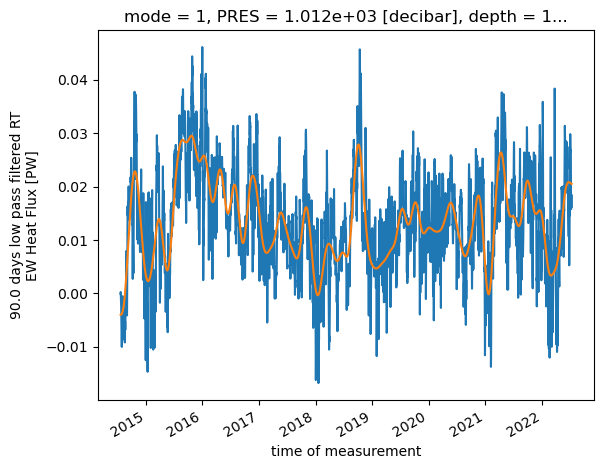

In [37]:
Qh_EW.where(Qh_EW.mask_EW).plot()
Qh_EW_lp.where(Qh_EW.mask_EW).plot()

### Get depth-accumulated transport

In [38]:
qz_EW = q_EW.sum('lon_EW')
qz_WW = q_WW.sum('lon_WW')
qz_MB = q_MB
qz_MB_grid = q_MB_grid.sum('lon_MB')
Q_MB_cumul = qz_MB.sel(depth=slice(None,P_ref))/1e6
Q_MB_grid_cumul = qz_MB_grid.sel(depth=slice(None,P_ref))/1e6
Q_EW_cumul = qz_EW.sel(depth=slice(None,P_ref))/1e6
Q_WW_cumul = qz_WW.sel(depth=slice(None,P_ref))/1e6

### Standard errors

In [39]:
# transport
SEw = rtf.std_error(Q_WW)
SEm = rtf.std_error(Q_MB)
SEm_grid = rtf.std_error(Q_MB_grid)
SEe = rtf.std_error(Q_EW)
SE = rtf.std_error((Q_WW.fillna(0) + Q_MB + Q_EW.fillna(0)))

# HF
SEhw = rtf.std_error(Qh_WW)
SEhm = rtf.std_error(Qh_MB)
SEhm_grid = rtf.std_error(Qh_MB_grid)
SEhe = rtf.std_error(Qh_EW)
SEh = rtf.std_error((Qh_WW.fillna(0) + Qh_MB + Qh_EW.fillna(0)))

# FF
SEfw = rtf.std_error(Qf_WW)
SEfm = rtf.std_error(Qf_MB)
SEfm_grid = rtf.std_error(Qf_MB_grid)
SEfe = rtf.std_error(Qf_EW)
SEf = rtf.std_error((Qf_WW.fillna(0) + Qf_MB + Qf_EW.fillna(0)))

'x has 5827 data cycles'

'Integral time scale (days) = 74.7627224209919'

' : Degrees of freedom = 77.93991191476319'

'x has 5827 data cycles'

'Integral time scale (days) = 137.60630359694483'

' : Degrees of freedom = 42.34544383277346'

'x has 5827 data cycles'

'Integral time scale (days) = 137.60579586270836'

' : Degrees of freedom = 42.34560007787533'

'x has 5827 data cycles'

'Integral time scale (days) = 146.25961161527485'

' : Degrees of freedom = 39.840116732481796'

'x has 5827 data cycles'

'Integral time scale (days) = 145.81376954586733'

' : Degrees of freedom = 39.961932389156516'

'x has 5827 data cycles'

'Integral time scale (days) = 59.447428202471414'

' : Degrees of freedom = 98.01937907479997'

'x has 5827 data cycles'

'Integral time scale (days) = 135.7906404702337'

' : Degrees of freedom = 42.91164678082007'

'x has 5827 data cycles'

'Integral time scale (days) = 135.68276270404795'

' : Degrees of freedom = 42.94576469311645'

'x has 5827 data cycles'

'Integral time scale (days) = 124.91868754332627'

' : Degrees of freedom = 46.64634343023327'

'x has 5827 data cycles'

'Integral time scale (days) = 114.7885444236768'

' : Degrees of freedom = 50.76290521197773'

'x has 5827 data cycles'

'Integral time scale (days) = 64.18904769316106'

' : Degrees of freedom = 90.77872642470797'

'x has 5827 data cycles'

'Integral time scale (days) = 396.8185233965699'

' : Degrees of freedom = 14.684294347259215'

'x has 5827 data cycles'

'Integral time scale (days) = 396.0969969412595'

' : Degrees of freedom = 14.71104311569455'

'x has 5827 data cycles'

'Integral time scale (days) = 185.18730941840488'

' : Degrees of freedom = 31.465439064372962'

'x has 5827 data cycles'

'Integral time scale (days) = 302.1679729203727'

' : Degrees of freedom = 19.283976205961217'

In [40]:
print('tot transport errors')
print(SE.values)
print(SEh.values)
print(SEf.values)

print('Midbasin non-grid')
print(SEm.values)
print(SEhm.values)
print(SEfm.values)


print('Midbasin .grid')
print(SEm_grid.values)
print(SEhm_grid.values)
print(SEfm_grid.values)

tot transport errors
0.570086873251867
0.003541525856791329
0.00254928323952067
Midbasin non-grid
0.48242292112594265
0.0033563867359890738
0.0027688994432427056
Midbasin .grid
0.4824210451231145
0.0033661739258261823
0.002777150865683693


# tot transports


### Add attributes to tot transport timeseries

In [41]:
Q_tot = Q_WW.fillna(0)+Q_EW.fillna(0)+Q_MB
Q_tot_lp = Q_WW_lp.fillna(0) + Q_MB_lp + Q_EW_lp.fillna(0)

Qh_tot = Qh_WW.fillna(0)+Qh_EW.fillna(0)+Qh_MB
Qh_tot_lp = Qh_WW_lp.fillna(0) + Qh_MB_lp + Qh_EW_lp.fillna(0)

Qf_tot = Qf_WW.fillna(0)+Qf_EW.fillna(0)+Qf_MB
Qf_tot_lp = Qf_WW_lp.fillna(0) + Qf_MB_lp + Qf_EW_lp.fillna(0)


Q_tot.coords['mask']=(Q_tot.mask_EW+Q_tot.mask_WW)
Q_tot = Q_tot.where(Q_tot.mask).compute()
Q_tot_lp = Q_tot_lp.where(Q_tot.mask).compute()

Qh_tot = Qh_tot.where(Q_tot.mask).compute()
Qh_tot_lp = Qh_tot_lp.where(Q_tot.mask).compute()

Qf_tot = Qf_tot.where(Q_tot.mask).compute()
Qf_tot_lp = Qf_tot_lp.where(Q_tot.mask).compute()

In [42]:
units = 'Sv'
name = 'sum of western, eastern, and mid-basin volume transport'
Q_tot.attrs = dict(long_name=name, units=units)
Q_tot_lp.attrs = dict(long_name=f'{1/lowcut} days low pass filtered {name}', units=units)

units = 'PW'
name = 'sum of western, eastern, and mid-basin freshwater transport'
Qh_tot.attrs = dict(long_name=name, units=units)
Qh_tot_lp.attrs = dict(long_name=f'{1/lowcut} days low pass filtered {name}', units=units)

units ='Sv'
name = 'sum of western, eastern, and mid-basin freshwater transport'
Qf_tot.attrs = dict(long_name=name, units=units)
Qf_tot_lp.attrs = dict(long_name=f'{1/lowcut} days low pass filtered {name}', units=units)

### Standard error pre 2017 - check regime shift

In [43]:
SE_pre_2017 = rtf.std_error(Q_tot.sel(TIME=slice(None,'2017')))
SEh_pre_2017 = rtf.std_error(Qh_tot.sel(TIME=slice(None,'2017')))
SEf_pre_2017 = rtf.std_error(Qf_tot.sel(TIME=slice(None,'2017')))

SE_after_2017 = rtf.std_error(Q_tot.sel(TIME=slice('2017',None)))
SEh_after_2017 = rtf.std_error(Qh_tot.sel(TIME=slice('2017',None)))
SEf_after_2017 = rtf.std_error(Qf_tot.sel(TIME=slice('2017',None)))

Q=Q_tot.sel(TIME=slice(None,'2017'))
print(f"Q Pre 2017 mean is {Q.mean('TIME').values}, std dev is {Q.std('TIME').values}, std error is {SE_pre_2017.values}")
Q=Qh_tot.sel(TIME=slice(None,'2017'))
print(f"Qh Pre 2017 mean is {Q.mean('TIME').values}, std dev is {Q.std('TIME').values}, std error is {SEh_pre_2017.values}")
Q=Qf_tot.sel(TIME=slice(None,'2017'))
print(f"Qf Pre 2017 mean is {Q.mean('TIME').values}, std dev is {Q.std('TIME').values}, std error is {SEf_pre_2017.values}")


'x has 2519 data cycles'

'Integral time scale (days) = 181.56817056938365'

' : Degrees of freedom = 13.87357702674765'

'x has 2519 data cycles'

'Integral time scale (days) = 105.37206676389201'

' : Degrees of freedom = 23.905766275272388'

'x has 2519 data cycles'

'Integral time scale (days) = 305.6131392953613'

' : Degrees of freedom = 8.242446662496079'

'x has 4038 data cycles'

'Integral time scale (days) = 125.88899404904835'

' : Degrees of freedom = 32.075877883548195'

'x has 4038 data cycles'

'Integral time scale (days) = 116.31370996031643'

' : Degrees of freedom = 34.71645777077933'

'x has 4038 data cycles'

'Integral time scale (days) = 141.83370563149697'

' : Degrees of freedom = 28.469960521875294'

Q Pre 2017 mean is 4.969307585112209, std dev is 3.9871082372833055, std error is 1.0704436264518769
Qh Pre 2017 mean is 0.05094688101202227, std dev is 0.026035554321699825, std error is 0.005324949508078326
Qf Pre 2017 mean is -0.022660835971328737, std dev is 0.012650439111062815, std error is 0.004406335159868452


In [44]:
Q=Q_tot.sel(TIME=slice('2017',None))
print(f"Q after 2017 mean is {Q.mean('TIME').values}, std dev is {Q.std('TIME').values}, std error is {SE_pre_2017.values}")
Q=Qh_tot.sel(TIME=slice('2017',None))
print(f"Qh after 2017 mean is {Q.mean('TIME').values}, std dev is {Q.std('TIME').values}, std error is {SEh_pre_2017.values}")
Q=Qf_tot.sel(TIME=slice('2017',None))
print(f"Qf after 2017 mean is {Q.mean('TIME').values}, std dev is {Q.std('TIME').values}, std error is {SEf_pre_2017.values}")

Q after 2017 mean is 4.083490255231761, std dev is 3.370730588605826, std error is 1.0704436264518769
Qh after 2017 mean is 0.043177288565819066, std dev is 0.02479940354009303, std error is 0.005324949508078326
Qf after 2017 mean is -0.016648478083279388, std dev is 0.00950557107682724, std error is 0.004406335159868452


### Check trends in time-series

In [45]:
dim = 'TIME'
fit, slope, intc, trend_significant = rtf.detrend_data(Q_tot,dim)

'x has 5827 data cycles'

'Integral time scale (days) = 145.81376954586733'

' : Degrees of freedom = 39.961932389156516'

# Prepare data to save

In [46]:
SE.attrs = {'name':'SE_Q_tot',
            'long_name':'Standard error',
            'description':'Standard error of total volume transport Q_tot, Rockall Trough',
             'units':'Sv'}
SEe.attrs = {'name':'SE_Q_EW',
            'long_name':'Standard error',
            'description':'Standard error of volume transport Q_EW at eastern wedge of Rockall Trough',
             'units':'Sv'}
SEm.attrs = {'name':'SE_Q_MB',
            'long_name':'Standard error',
            'description':'Standard error of mid basin volume transport Q_MB of Rockall Trough',
             'units':'Sv'}
SEw.attrs = {'name':'SE_Q_WW',
            'long_name':'Standard error',
            'description':'Standard error of volume transport Q_WW at western wedge of Rockall Trough',
             'units':'Sv'}

SEh.attrs = {'name':'SE_Qh_tot',
            'long_name':'Standard error',
            'description':'Standard error of total heat transport Qh_tot, Rockall Trough',
             'units':'PW'}
SEhe.attrs = {'name':'SE_Qh_EW',
            'long_name':'Standard error',
            'description':'Standard error of heat transport Qh_EW at eastern wedge of Rockall Trough',
             'units':'PW'}
SEhm.attrs = {'name':'SE_Qh_MB',
            'long_name':'Standard error',
            'description':'Standard error of mid basin heat transport Qh_MB of Rockall Trough',
             'units':'PW'}
SEhw.attrs = {'name':'SE_Qh_WW',
            'long_name':'Standard error',
            'description':'Standard error of heat transport Qh_WW at western wedge of Rockall Trough',
             'units':'PW'}

SEf.attrs = {'name':'SE_Qf_tot',
            'long_name':'Standard error',
            'description':'Standard error of total freshwater transport Qf_tot, Rockall Trough',
             'units':'Sv'}
SEfe.attrs = {'name':'SE_Qf_EW',
            'long_name':'Standard error',
            'description':'Standard error of freshwater transport Qf_EW at eastern wedge of Rockall Trough',
             'units':'Sv'}
SEfm.attrs = {'name':'SE_Qf_MB',
            'long_name':'Standard error',
            'description':'Standard error of mid basin freshwater transport Qf_MB of Rockall Trough',
             'units':'Sv'}
SEfw.attrs = {'name':'SE_Qf_WW',
            'long_name':'Standard error',
            'description':'Standard error of freshwater transport Qf_WW at western wedge of Rockall Trough',
             'units':'Sv'}

In [47]:
RT_Q_Qh_Qf = xr.merge([Q_tot.rename('Q_tot'),Q_tot_lp.rename('Q_tot_lp'),SE.rename('SE_tot'),
          Q_EW.rename('Q_EW'),Q_EW_lp.rename('Q_EW_lp'),SEe.rename('SE_EW'),
          Q_MB.rename('Q_MB'),Q_MB_lp.rename('Q_MB_lp'),SEm.rename('SE_MB'),
          Q_WW.rename('Q_WW'),Q_WW_lp.rename('Q_WW_lp'),SEw.rename('SE_WW'),
          Qh_tot.rename('Qh_tot'),Qh_tot_lp.rename('Qh_tot_lp'),SEh.rename('SEh_tot'),
          Qh_EW.rename('Qh_EW'),Qh_EW_lp.rename('Qh_EW_lp'),SEhe.rename('SEh_EW'),
          Qh_MB.rename('Qh_MB'),Qh_MB_lp.rename('Qh_MB_lp'),SEhm.rename('SEh_MB'),
          Qh_WW.rename('Qh_WW'),Qh_WW_lp.rename('Qh_WW_lp'),SEhw.rename('SEh_WW'),
          Qf_tot.rename('Qf_tot'),Qf_tot_lp.rename('Qf_tot_lp'),SEf.rename('SEf_tot'),
          Qf_EW.rename('Qf_EW'),Qf_EW_lp.rename('Qf_EW_lp'),SEfe.rename('SEf_EW'),
          Qf_MB.rename('Qf_MB'),Qf_MB_lp.rename('Qf_MB_lp'),SEfm.rename('SEf_MB'),
          Qf_WW.rename('Qf_WW'),Qf_WW_lp.rename('Qf_WW_lp'),SEfw.rename('SEf_WW'),
         ]).drop(['PRES','depth','mask_WW','mode','mask_EW','lat_MB','lon_MB','mask'])
RT_q = xr.merge([q_EW.rename('q_EW').drop(['mode','x']),q_MB.rename('q_MB'),q_WW.rename('q_WW')])

In [48]:
Q_MB_SAfix
# Q_MB_CTfix
# Q_MB_SAfix_CTfix

<xarray.DataArray (TIME: 5827)>
array([6.2024446 , 6.60013635, 6.84632973, ..., 2.07914343, 1.71112896,
       1.28650469])
Coordinates:
  * TIME     (TIME) datetime64[ns] 2014-07-21T12:00:00 ... 2022-07-12T12:00:00
Attributes:
    name:         RT_Q_MB_SAfix
    units:        Sv
    long_name:    RT MB Volume Transport SA fixed
    description:  As Q_MB but holding salinity fixed at temporal mean at all ...

In [49]:
RT_sens_expt = xr.merge([ Q_MB_CTfix.rename('Q_MB_CTfix'),Q_MB_CTfix_lp.rename('Q_MB_CTfix_lp'),
                          Q_MB_SAfix.rename('Q_MB_SAfix'),Q_MB_SAfix_lp.rename('Q_MB_SAfix_lp'),
                          Q_MB_SAfix_CTfix.rename('Q_MB_SAfix_CTfix'),Q_MB_SAfix_CTfix_lp.rename('Q_MB_SAfix_CTfix_lp'),
                          Q_MB_EB_CTvar.rename('Q_MB_EB_CTvar'),Q_MB_EB_CTvar_lp.rename('Q_MB_EB_CTvar_lp'),
                          Q_MB_WB_CTvar.rename('Q_MB_WB_CTvar'),Q_MB_WB_CTvar_lp.rename('Q_MB_WB_CTvar_lp'),
                          Qh1_EW.rename('Qh1_EW'),Qh1_EW_lp.rename('Qh1_EW_lp'),
                          Qh1_MB.rename('Qh1_MB'),Qh1_MB_lp.rename('Qh1_MB_lp'),
                          Qh1_WW.rename('Qh1_WW'),Qh1_WW_lp.rename('Qh1_WW_lp'),
                          Qh2_EW.rename('Qh2_EW'),Qh2_EW_lp.rename('Qh2_EW_lp'),
                          Qh2_MB.rename('Qh2_MB'),Qh2_MB_lp.rename('Qh2_MB_lp'),
                          Qh2_WW.rename('Qh2_WW'),Qh2_WW_lp.rename('Qh2_WW_lp'),
                          Qf1_EW.rename('Qf1_EW'),Qf1_EW_lp.rename('Qf1_EW_lp'),
                          Qf1_MB.rename('Qf1_MB'),Qf1_MB_lp.rename('Qf1_MB_lp'),
                          Qf1_WW.rename('Qf1_WW'),Qf1_WW_lp.rename('Qf1_WW_lp'),
                          Qf2_EW.rename('Qf2_EW'),Qf2_EW_lp.rename('Qf2_EW_lp'),
                          Qf2_MB.rename('Qf2_MB'),Qf2_MB_lp.rename('Qf2_MB_lp'),
                          Qf2_WW.rename('Qf2_WW'),Qf2_WW_lp.rename('Qf2_WW_lp'),
         ]).drop(['PRES','depth','mask_WW','mode','mask_EW','lat_MB','lon_MB'])

In [50]:
date_str_start = '201407'
date_str_end = '202207'
global_attrs = {'title' : f'Rockall Trough transport data {date_str_start[-2:]}/{date_str_start[:-2]}-{date_str_end[-2:]}/{date_str_end[:-2]} v0',
'institution' : 'Scottish Association for Marine Science, Scottish Marine Institute Oban, Argyll, PA37 1QA, UK',
'history' : 'Delayed time processed quality controlled',
'description':'Rockall Trough transport. The timeseries is a extended version of the one published in Fraser et al. (2022, JGR Ocean, see references)',
'id' : f'{fn_base}_{date_str_start}_{date_str_end}_{fn_version}',
'pi':'Stuart Cunningham',
'creator_name' : 'Kristin Burmeister',
'creator_url' : 'https://orcid.org/0000-0003-3881-0298',
'contributor_name' : 'Neil Fraser, Lewis Drysdale, Sam Jones, Stuart Cunningham',
'source' : 'Derived from moored current meter observations and model analysis and reanalysis from GLORYS12V1',
'project' : 'Climate Linked Atlantic Sector Science',
'references' : 'https://doi.org/10.1029/2022JC019291, http://www.o-snap.org',
'area' : 'North Atlantic Ocean',
'time_coverage_start' : f'{RT_Q_Qh_Qf.TIME.min().dt.strftime("%Y-%m-%d %r").values}',
'time_coverage_end' : f'{RT_Q_Qh_Qf.TIME.max().dt.strftime("%Y-%m-%d %r").values}',
'citation' : 'These data were collected and made freely available by the OSNAP project and the national programs that contribute to it.',
'acknowledgement' : 'Funding source: the UK Natural Environment Research Council (NERC), UK OSNAP project', 
'date_created' : datetime.datetime.now().strftime("%Y-%m-%d %r"),
'date_modified' : datetime.datetime.now().strftime("%Y-%m-%d %r")}
RT_Q_Qh_Qf.attrs = global_attrs
RT_sens_expt.attrs = global_attrs
RT_sens_expt.attrs['id'] = f'{fn_base}_sens_exp_{date_str_start}_{date_str_end}_{fn_version}'

In [51]:
ds_q_RTMB = ds_RT_MB_grid.drop('PRES').rename({'TIME':'time'})
ds_q_RTMB = ds_q_RTMB.rename({'lon_MB':'lon','lat_MB':'lat','dx_MB':'dx'})
ds_q_RTMB.coords['dz']=dz

In [52]:
ds_q_RTEW = xr.Dataset()
ds_q_RTEW['q']=(RT_q.reset_coords().q_EW.rename('q')).rename({'lon_EW':'lon'})
ds_q_RTEW.coords['lat']=RT_q.reset_coords().lat.rename({'lon_EW':'lon'})
ds_q_RTEW.coords['dx']=dx_EW.rename({'lon_EW':'lon'})
ds_q_RTEW.coords['dz']=dz
mask = ds_q_RTEW.q.notnull()
ds_q_RTEW['CT'] = (ds_RT.TG_EAST*ds_q_RTEW.q.notnull()).where(mask)
ds_q_RTEW['SA'] = (ds_RT.SG_EAST*ds_q_RTEW.q.notnull()).where(mask)
ds_q_RTEW = ds_q_RTEW.drop('PRES').rename({'TIME':'time'})

In [53]:
ds_q_RTWW = xr.Dataset()
ds_q_RTWW['q']=(RT_q.reset_coords().q_WW.rename('q')).rename({'lon_WW':'lon'})
ds_q_RTWW.coords['lat']=RT_q.reset_coords().lat_WW.rename({'lon_WW':'lon'})
ds_q_RTWW.coords['dx']=dx_WW.rename({'lon_WW':'lon'})
ds_q_RTWW.coords['dz']=dz
mask = ds_q_RTWW.q.notnull()
ds_q_RTWW['CT'] = (ds_RT.TG_WEST*ds_q_RTWW.q.notnull()).where(mask)
ds_q_RTWW['SA'] = (ds_RT.SG_WEST*ds_q_RTWW.q.notnull()).where(mask)
ds_q_RTWW = ds_q_RTWW.drop('PRES').rename({'TIME':'time'})

In [54]:
RT_q['dx_EW']=dx_EW
RT_q['dx_WW']=dx_WW
# RT_q['dx_MB']=dx_MB
RT_q['dz']=ds_RT.dz
 
RT_q['SA_MB'] = (ds_RT.SG_WEST + ds_RT.SG_EAST)/2
RT_q['CT_MB'] = (ds_RT.TG_WEST + ds_RT.TG_EAST)/2

mask = RT_q.q_EW.notnull()
RT_q['CT_EW'] = (ds_RT.TG_EAST*RT_q.q_EW.notnull()).where(mask)
RT_q['SA_EW'] = (ds_RT.SG_EAST*RT_q.q_EW.notnull()).where(mask)

mask = RT_q.q_WW.notnull()
RT_q['CT_WW'] = (ds_RT.TG_WEST*RT_q.q_WW.notnull()).where(mask)
RT_q['SA_WW'] = (ds_RT.SG_WEST*RT_q.q_WW.notnull()).where(mask)

In [55]:
RT_Q_Qh_Qf.to_netcdf(f'{data_out_path}{fn_base}_{date_str_start}_{date_str_end}_{fn_version}.nc')
RT_q.to_netcdf(f'{data_out_path}RT_q_time_series_{date_str_start}_{date_str_end}_{fn_version}.nc')
RT_Q_Ek.to_netcdf(f'{data_out_path}RT_Ekman_time_series_{date_str_start}_{date_str_end}_{fn_version}.nc')

In [56]:
ds_q_RTMB.to_netcdf(f'{data_out_path}q_RTMB_time_series_{date_str_start}_{date_str_end}_{fn_version}.nc')
ds_q_RTWW.to_netcdf(f'{data_out_path}q_RTWW_time_series_{date_str_start}_{date_str_end}_{fn_version}.nc')
ds_q_RTEW.to_netcdf(f'{data_out_path}q_RTEW_time_series_{date_str_start}_{date_str_end}_{fn_version}.nc')

In [57]:
RT_sens_expt.to_netcdf(f'{data_out_path}{fn_base}_sens_exp_{date_str_start}_{date_str_end}_{fn_version}.nc')

In [58]:
RT_Q_Qh_Qf.to_netcdf((global_data_path/f'data_RT_mooring/{fn_base}_{date_str_start}_{date_str_end}_{fn_version}.nc'))
RT_q.to_netcdf((global_data_path/f'data_RT_mooring/RT_q_time_series_{date_str_start}_{date_str_end}_{fn_version}.nc'))
RT_Q_Ek.to_netcdf((global_data_path/f'data_RT_mooring/RT_Ekman_time_series_{date_str_start}_{date_str_end}_{fn_version}.nc'))

In [59]:
ds_q_RTMB.to_netcdf((global_data_path/f'data_RT_mooring/q_RTMB_time_series_{date_str_start}_{date_str_end}_{fn_version}.nc'))
ds_q_RTWW.to_netcdf((global_data_path/f'data_RT_mooring/q_RTWW_time_series_{date_str_start}_{date_str_end}_{fn_version}.nc'))
ds_q_RTEW.to_netcdf((global_data_path/f'data_RT_mooring/q_RTEW_times_eries_{date_str_start}_{date_str_end}_{fn_version}.nc'))

# Plot timeseries

In [60]:
RT_Q_Qh_Qf = xr.open_dataset(f'{data_out_path}{fn_base}_{date_str_start}_{date_str_end}_{fn_version}.nc')
RT_q = xr.open_dataset(f'{data_out_path}RT_q_time_series_{date_str_start}_{date_str_end}_{fn_version}.nc')
RT_Q_Ek = xr.open_dataset(f'{data_out_path}RT_Ekman_time_series_{date_str_start}_{date_str_end}_{fn_version}.nc')

In [61]:
ds_q_RTMB = xr.open_dataset(f'{data_out_path}q_RTMB_time_series_{date_str_start}_{date_str_end}_{fn_version}.nc')
ds_q_RTWW = xr.open_dataset(f'{data_out_path}q_RTWW_time_series_{date_str_start}_{date_str_end}_{fn_version}.nc')
ds_q_RTEW = xr.open_dataset(f'{data_out_path}q_RTEW_time_series_{date_str_start}_{date_str_end}_{fn_version}.nc')
ds_q_RTEW_old = xr.open_dataset(f'{local_data_path_v0}\q_RTEW_time_series_{date_str_start}_{date_str_end}_v0.nc')

In [ ]:
fs=14
font = {'weight' : 'normal',
        'size'   : fs}
plt.rc('font', **font)

## Rockall Trough Volume Transport

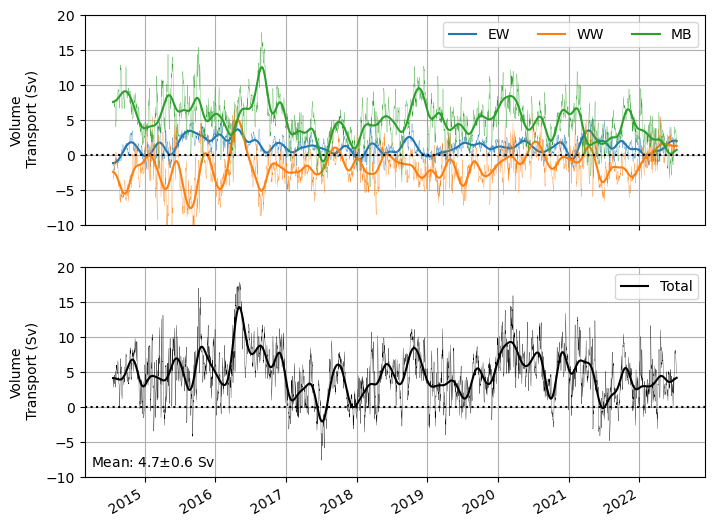

In [62]:
fig,axs = plt.subplots(2,1,sharex=True,figsize=[8,6])

ylabel_name = ['Volume\n Transport (Sv)','Heat\n Transport (PW)','Freshwater\n Transport (Sv)']
# build a rectangle in axes coords
left = .01
bottom = .05

ax=axs[0]
RT_Q_Qh_Qf.Q_EW.plot.line(ax=ax,linewidth=.2,color='C0')
RT_Q_Qh_Qf.Q_EW_lp.plot.line(ax=ax,color='C0',label='EW')

RT_Q_Qh_Qf.Q_WW.plot.line(ax=ax,linewidth=.2,color='C1')
RT_Q_Qh_Qf.Q_WW_lp.plot.line(ax=ax,color='C1',label='WW')

RT_Q_Qh_Qf.Q_MB.plot.line(ax=ax,linewidth=.2,color='C2')
RT_Q_Qh_Qf.Q_MB_lp.plot.line(ax=ax,color='C2',label='MB')


ax=axs[1]
RT_Q_Qh_Qf.Q_tot.plot.line('k',ax=ax,linewidth=.2)
RT_Q_Qh_Qf.Q_tot_lp.plot.line('k',ax=ax,label='Total')
ax.text(left, bottom, ('Mean: %2.1f$\pm$%2.1f Sv' %(RT_Q_Qh_Qf.Q_tot.mean().values,RT_Q_Qh_Qf.SE_tot.values)),
        fontsize=10,
        transform=ax.transAxes)


for i,ax in enumerate(axs):
    ax.grid()
    ax.set_title('')
    ax.set_ylabel(ylabel_name[0])
    ax.set_xlabel('')
    ax.legend(ncol = len(ax.lines))
    ax.set_ylim([-10, 20])
    ax.axhline(0,color='k',ls=':')

fig.savefig(f'{fig_out_path}Rockall_Trough_volume_transports_{date_str_start}_{date_str_end}_{fn_version}.png',dpi=300,bbox_inches='tight')

## Rockall Trough Heat Transport

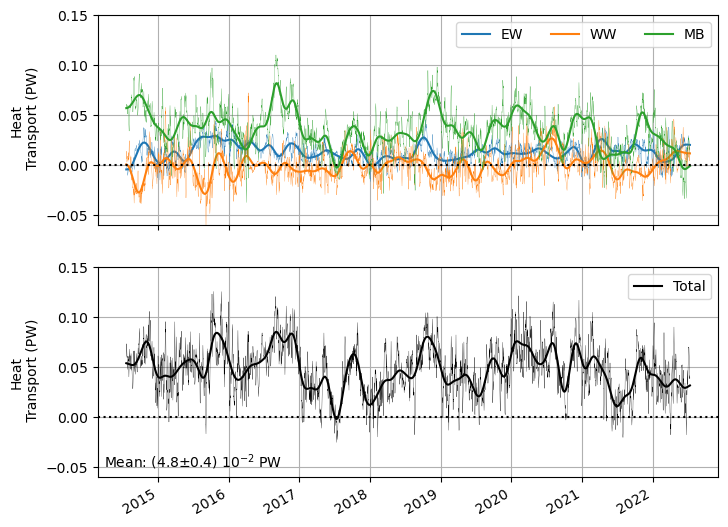

In [63]:
fig,axs = plt.subplots(2,1,sharex=True,figsize=[8,6])

ylabel_name = ['Volume\n Transport (Sv)','Heat\n Transport (PW)','Freshwater\n Transport (Sv)']
# build a rectangle in axes coords
left = .01
bottom = .05

ax=axs[0]
RT_Q_Qh_Qf.Qh_EW.plot.line(ax=ax,linewidth=.2,color='C0')
RT_Q_Qh_Qf.Qh_EW_lp.plot.line(ax=ax,color='C0',label='EW')

RT_Q_Qh_Qf.Qh_WW.plot.line(ax=ax,linewidth=.2,color='C1')
RT_Q_Qh_Qf.Qh_WW_lp.plot.line(ax=ax,color='C1',label='WW')

RT_Q_Qh_Qf.Qh_MB.plot.line(ax=ax,linewidth=.2,color='C2')
RT_Q_Qh_Qf.Qh_MB_lp.plot.line(ax=ax,color='C2',label='MB')


ax=axs[1]
RT_Q_Qh_Qf.Qh_tot.plot.line('k',ax=ax,linewidth=.2)
RT_Q_Qh_Qf.Qh_tot_lp.plot.line('k',ax=ax,label='Total')
ax.text(left, bottom, ('Mean: (%2.1f$\pm$%2.1f) 10$^{-2}$ PW' %(RT_Q_Qh_Qf.Qh_tot.mean().values*1e2,RT_Q_Qh_Qf.SEh_tot.values*1e2)),
        fontsize=10,
        transform=ax.transAxes)


for i,ax in enumerate(axs):
    ax.grid()
    ax.set_title('')
    ax.set_ylabel(ylabel_name[1])
    ax.set_xlabel('')
    ax.legend(ncol = len(ax.lines))
    ax.set_ylim([-.06, .15])
    ax.axhline(0,color='k',ls=':')

fig.savefig(f'{fig_out_path}Rockall_Trough_heat_transports_{date_str_start}_{date_str_end}_{fn_version}.png',dpi=300,bbox_inches='tight')

## Rockall Trough Freshwater Transport

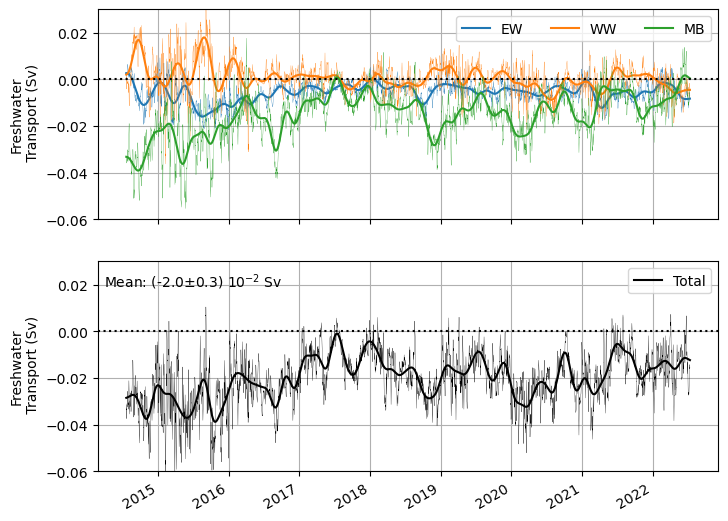

In [64]:
fig,axs = plt.subplots(2,1,sharex=True,figsize=[8,6])

ylabel_name = ['Volume\n Transport (Sv)','Heat\n Transport (PW)','Freshwater\n Transport (Sv)']
# build a rectangle in axes coords
left = .01
bottom = .95

ax=axs[0]
RT_Q_Qh_Qf.Qf_EW.plot.line(ax=ax,linewidth=.2,color='C0')
RT_Q_Qh_Qf.Qf_EW_lp.plot.line(ax=ax,color='C0',label='EW')

RT_Q_Qh_Qf.Qf_WW.plot.line(ax=ax,linewidth=.2,color='C1')
RT_Q_Qh_Qf.Qf_WW_lp.plot.line(ax=ax,color='C1',label='WW')

RT_Q_Qh_Qf.Qf_MB.plot.line(ax=ax,linewidth=.2,color='C2')
RT_Q_Qh_Qf.Qf_MB_lp.plot.line(ax=ax,color='C2',label='MB')


ax=axs[1]
RT_Q_Qh_Qf.Qf_tot.plot.line('k',ax=ax,linewidth=.2)
RT_Q_Qh_Qf.Qf_tot_lp.plot.line('k',ax=ax,label='Total')
ax.text(left, bottom,('Mean: (%2.1f$\pm$%2.1f) 10$^{-2}$ Sv' %(RT_Q_Qh_Qf.Qf_tot.mean().values*1e2,RT_Q_Qh_Qf.SEf_tot.values*1e2)),
        fontsize=10,va='top',
        transform=ax.transAxes)


for i,ax in enumerate(axs):
    ax.grid()
    ax.set_title('')
    ax.set_ylabel(ylabel_name[2])
    ax.set_xlabel('')
    ax.legend(ncol = len(ax.lines))
    ax.set_ylim([-.06, .03])
    ax.axhline(0,color='k',ls=':')

fig.savefig(f'{fig_out_path}Rockall_Trough_freshwater_transports_{date_str_start}_{date_str_end}_{fn_version}.png',dpi=300,bbox_inches='tight')

## Rockall Trough Total Transport Timeseries

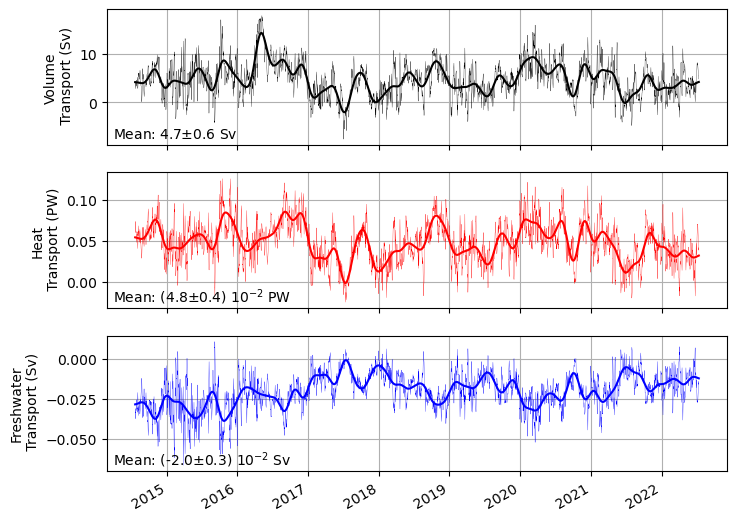

In [65]:
fig,axs = plt.subplots(3,1,sharex=True,figsize=[8,6])

ylabel_name = ['Volume\n Transport (Sv)','Heat\n Transport (PW)','Freshwater\n Transport (Sv)']
# build a rectangle in axes coords
left = .01
bottom = .05

# print(SE.values)
# print(SEh.values)
# print(SEf.values) Q_MB_grid

RT_Q_Qh_Qf.Q_tot.plot.line('k',ax=axs[0],linewidth=.2)
RT_Q_Qh_Qf.Q_tot_lp.plot.line('k',ax=axs[0],)
axs[0].text(left, bottom, ('Mean: %2.1f$\pm$%2.1f Sv' %(RT_Q_Qh_Qf.Q_tot.mean().values,RT_Q_Qh_Qf.SE_tot.values)),
        fontsize=10,
        transform=axs[0].transAxes)

RT_Q_Qh_Qf.Qh_tot.plot.line('r',ax=axs[1],linewidth=.2)
RT_Q_Qh_Qf.Qh_tot_lp.plot.line('r',ax=axs[1],)
axs[1].text(left, bottom, ('Mean: (%2.1f$\pm$%2.1f) 10$^{-2}$ PW' %(RT_Q_Qh_Qf.Qh_tot.mean().values*1e2,RT_Q_Qh_Qf.SEh_tot.values*1e2)),
        fontsize=10,
        transform=axs[1].transAxes)

RT_Q_Qh_Qf.Qf_tot.plot.line('b',ax=axs[2],linewidth=.2)
RT_Q_Qh_Qf.Qf_tot_lp.plot.line('b',ax=axs[2],)
axs[2].text(left, bottom, ('Mean: (%2.1f$\pm$%2.1f) 10$^{-2}$ Sv' %(RT_Q_Qh_Qf.Qf_tot.mean().values*1e2,RT_Q_Qh_Qf.SEf_tot.values*1e2)),
        fontsize=10,
        transform=axs[2].transAxes)

for i,ax in enumerate(axs):
    ax.grid()
    ax.set_title('')
    ax.set_ylabel(ylabel_name[i])
    ax.set_xlabel('')

fig.savefig(f'{fig_out_path}Rockall_Trough_total_transports_{date_str_start}_{date_str_end}_{fn_version}.png',dpi=300,bbox_inches='tight')

## Rockall Trough Mean Sections

In [66]:
ds_q_RT = xr.concat([ds_q_RTWW,ds_q_RTMB,ds_q_RTEW],'lon')

# ds_GEBCO.elevation.interp(lon=lon_WW, lat=lat_WW).drop(['lon','lat'])
ds_q_RT['bathy']=ds_GEBCO.elevation.interp(lon=ds_q_RT.lon, lat=ds_q_RT.lat)

def calc_SA_CT_sigma0(ds):
    
    sigma0_attrs = {'long_name':'Potential density referenced to 0dbar',
                   'description':'Potential density TEOS-10', 
                 'units':'kg/m^3'}
    
    ds['sigma0'] = xr.apply_ufunc(gsw.sigma0,
                  ds.SA,ds.CT,
                  dask = 'parallelized',output_dtypes=[float,])
    ds.sigma0.attrs = sigma0_attrs
    return ds

ds_q_RT = calc_SA_CT_sigma0(ds_q_RT)
ds_q_RT['v']=(ds_q_RT.q/(ds_q_RT.dx*ds_q_RT.dz))

vel_attrs = {'long_name':'Across section velocity',
                 'units':'m/s'}
CT_attrs = {'long_name':'Conservative temperature',
          'description':'conservative temperature TEOS-10',
          'units':'degC'}
SA_attrs = {'long_name':'Absolute salinity',
        'description':'Absolute salinity TEOS-10',
         'units':'g/kg'}

ds_q_RT.v.attrs = vel_attrs
ds_q_RT.CT.attrs = CT_attrs
ds_q_RT.SA.attrs = SA_attrs

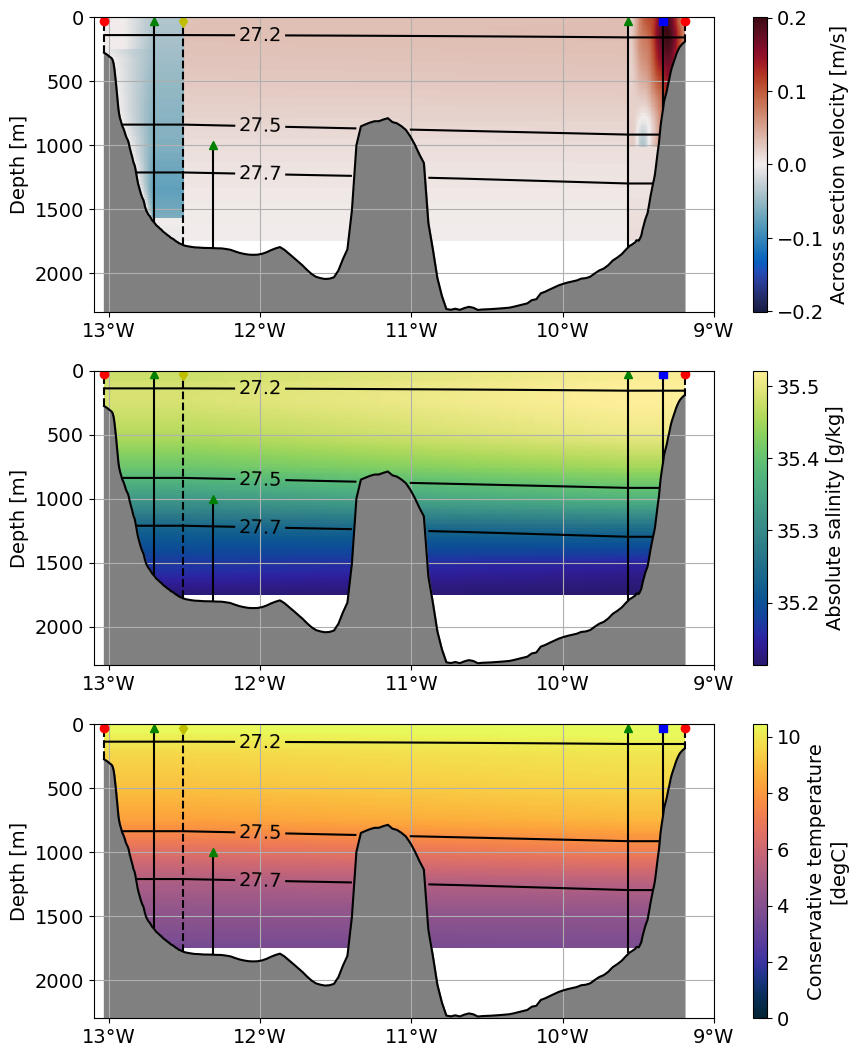

In [67]:
## figure
plt.rcParams.update({'font.size': 14})

xticks = np.arange(-13.,-8,1)
xticklabels = ['13°W','12°W','11°W','10°W','9°W']

sigma_contours = [27.2,27.5, 27.7]
manual_locations = [(-12,100),(-12,900),(-12,1250)]

# Set up figure
fig,axs = plt.subplots(3,1,figsize=[10,13])

ds_q_RT.v.mean('time',keep_attrs=True).plot(ax=axs[0],y='depth',x='lon',yincrease=False,cmap=cm.cm.balance)
ds_q_RT.SA.mean('time',keep_attrs=True).plot(ax=axs[1],y='depth',x='lon',yincrease=False,cmap=cm.cm.haline)
ds_q_RT.CT.mean('time',keep_attrs=True).plot(ax=axs[2],y='depth',x='lon',yincrease=False,cmap=cm.cm.thermal,vmin=0)

for ax in axs:
    ax.fill_between(ds_q_RT.lon, -ds_q_RT.bathy,2300,color='grey')
    (-ds_q_RT.bathy).plot.line('k',ax=ax)
    CS = ds_q_RT.sigma0.mean('time',keep_attrs=True).where(ds_q_RT.depth<=-ds_q_RT.bathy).plot.contour(
        ax=ax,x='lon',levels=sigma_contours,yincrease=False,colors='k')
    ax.clabel(CS,manual=manual_locations)
    
    ax.vlines(lon_RTWB,-ds_q_RT.bathy.sel(lon=lon_RTWB,method='nearest'), 0,colors='k',ls='--')
    ax.vlines(lon_RTES,-ds_q_RT.bathy.sel(lon=lon_RTES,method='nearest'), 0,colors='k',ls='--')
    ax.vlines(lon_RTWS,-ds_q_RT.bathy.sel(lon=lon_RTWS,method='nearest'), 0,colors='k',ls='--')
    
    ax.vlines(lon_RTADCP,-ds_q_RT.bathy.sel(lon=lon_RTADCP,method='nearest'), 0,colors='k')
    ax.vlines(lon_RTEB,-ds_q_RT.bathy.sel(lon=lon_RTEB,method='nearest'), 50,colors='k')
    ax.vlines(lon_RTWB1,-ds_q_RT.bathy.sel(lon=lon_RTWB1,method='nearest'), 50,colors='k')
    ax.vlines(lon_RTWB2,-ds_q_RT.bathy.sel(lon=lon_RTWB2,method='nearest'), 1000,colors='k')
    
    d= 30.
    ax.plot([lon_RTES,lon_RTWS],[d,d],'or')
    ax.plot([lon_RTWB],[d],'dy')
    ax.plot([lon_RTADCP],[d],'sb')
    ax.plot([lon_RTEB,lon_RTWB1],[d,d],'^g')
    ax.plot([lon_RTWB2],[1000],'^g')
    
    ax.set_xlim([-13.1,-9.])
    ax.set_xlabel('')
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels,fontsize=14)
    ax.grid()

    ax.set_ylabel('Depth [m]')
    ax.set_ylim([2300,0])

fig.savefig(f'{fig_out_path}Rockall_Trough_mean_sections_{date_str_start}_{date_str_end}_{fn_version}.png',dpi=300,bbox_inches='tight')

## EW, WW and glider

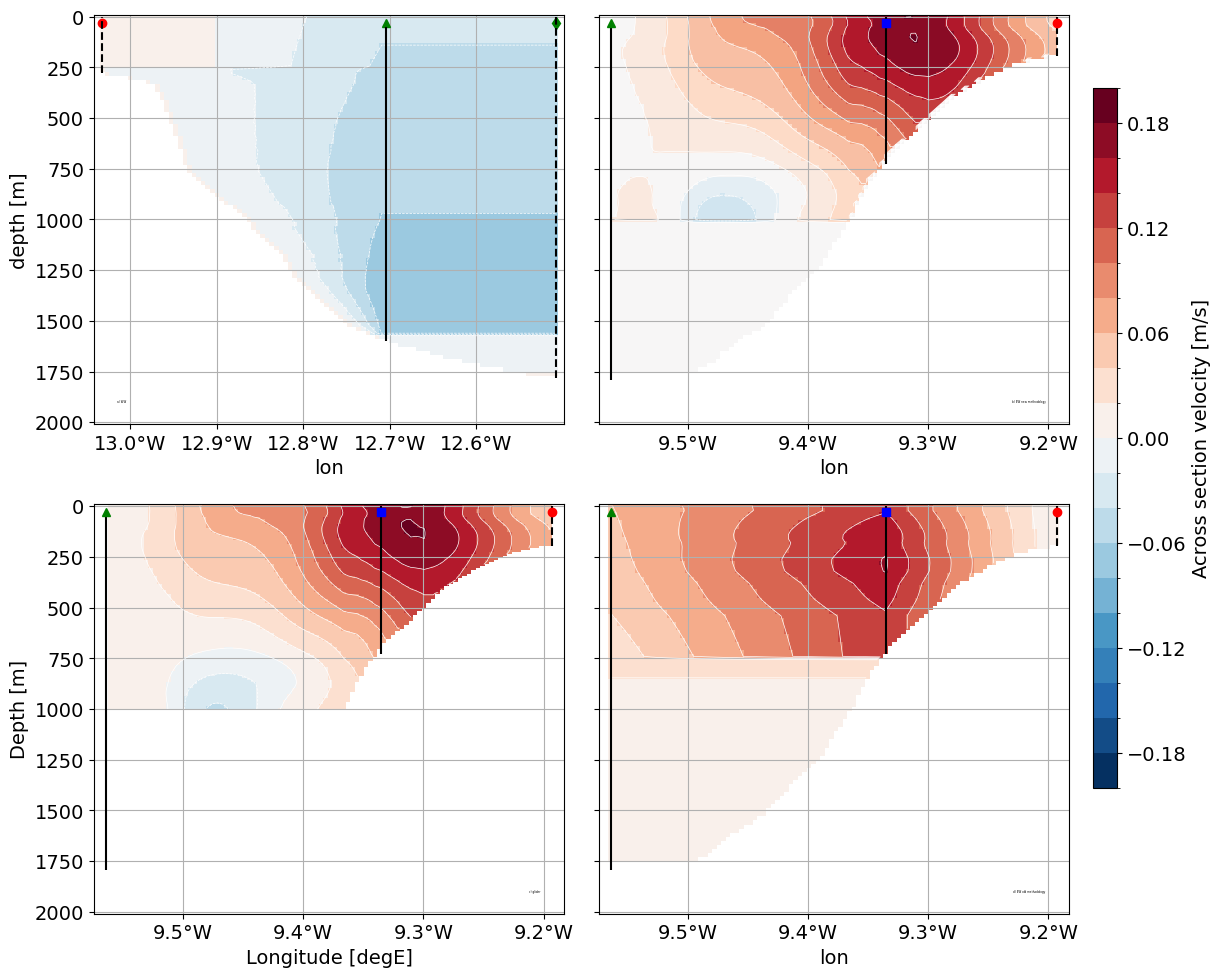

In [72]:
v_glider = ds_glider.vcur
v_glider['depth']=abs(v_glider.depth)

v_old=(ds_q_RTEW_old.q/(ds_q_RTEW_old.dx*ds_q_RTEW_old.dz))
# v_old.mean('time').plot()
# v_glider.interp_like(ds_q_RT.PRES).mean('time').plot()
#WW ds_q_RT.v.sel(lon=ds_q_RTWW.lon).mean('time').plot()
#EW ds_q_RT.v.sel(lon=ds_q_RTEW.lon).mean('time').plot()

xticks_WW = np.arange(-13.,lon_RTWB,.1)
xticklabels_WW = ['13.0°W','12.9°W','12.8°W','12.7°W','12.6°W']

xticks_EW = np.arange(-9.5,lon_RTES,.1)
xticklabels_EW = ['9.5°W','9.4°W','9.3°W','9.2°W']

fig,axs = plt.subplots(2,2,figsize=[12,10],sharey=True)

vmin,vmax,levs=-0.2,0.2,21

ax = axs[0,0]
v = ds_q_RT.v.sel(lon=ds_q_RTWW.lon).mean('time')
v.depth['long_name']='Depth'
im_hdl = v.plot(
    x='lon',ax=ax,add_colorbar=False,yincrease=False,
    vmin=vmin,vmax=vmax,levels=levs,cmap='RdBu_r')
v.plot.contour(ax=ax,x='lon',colors='w',linewidths=.5,
               yincrease=False,
               vmin=vmin,vmax=vmax,levels=levs)
ax.plot([lon_RTWS],[d],'or')
ax.plot([lon_RTWB],[d],'dg')
ax.plot([lon_RTWB1],[d],'^g')

ax.vlines(lon_RTWB,-ds_q_RT.bathy.sel(lon=lon_RTWB,method='nearest'), 0,colors='k',ls='--')
ax.vlines(lon_RTWS,-ds_q_RT.bathy.sel(lon=lon_RTWS,method='nearest'), 0,colors='k',ls='--')
ax.vlines(lon_RTWB1,-ds_q_RT.bathy.sel(lon=lon_RTWB1,method='nearest'), 50,colors='k')

ax.set_xlim([lon_RTWS-0.01,lon_RTWB+0.01])
ax.set_xticks(xticks_WW)
ax.set_xticklabels(xticklabels_WW,fontsize=14)

ax.text(0.05, 0.05,f'a) WW',
        transform=ax.transAxes, fontsize=fs,
         verticalalignment='bottom',horizontalalignment='left')

ax = axs[0,1]
v = ds_q_RT.v.sel(lon=ds_q_RTEW.lon).mean('time')
im_hdl = v.plot(
    x='lon',ax=ax,add_colorbar=False,yincrease=False,
    vmin=vmin,vmax=vmax,levels=levs,cmap='RdBu_r')
v.plot.contour(ax=ax,x='lon',colors='w',linewidths=.5,
               yincrease=False,
               vmin=vmin,vmax=vmax,levels=levs)
ax.text(0.95, 0.05,f'b) EW new methodology',
        transform=ax.transAxes, fontsize=fs,
         verticalalignment='bottom',horizontalalignment='right')

ax = axs[1,0]
v = v_glider.mean('time')
im_hdl = v.plot(
    x='lon',ax=ax,add_colorbar=False,yincrease=False,
    vmin=vmin,vmax=vmax,levels=levs,cmap='RdBu_r')
v.plot.contour(ax=ax,x='lon',colors='w',linewidths=.5,
               yincrease=False,
               vmin=vmin,vmax=vmax,levels=levs)
ax.text(0.95, 0.05,f'c) glider',
        transform=ax.transAxes, fontsize=fs,
         verticalalignment='bottom',horizontalalignment='right')

ax = axs[1,1]
v = v_old.mean('time')
im_hdl = v.plot(
    x='lon',ax=ax,add_colorbar=False,yincrease=False,
    vmin=vmin,vmax=vmax,levels=levs,cmap='RdBu_r')
v.plot.contour(ax=ax,x='lon',colors='w',linewidths=.5,
               yincrease=False,
               vmin=vmin,vmax=vmax,levels=levs)

ax.text(0.95, 0.05,f'd) EW old methodology',
        transform=ax.transAxes, fontsize=fs,
         verticalalignment='bottom',horizontalalignment='right')

for i,ax in enumerate(axs.flat):
    ax.grid()
    if i>0:
        ax.vlines(lon_RTADCP,-ds_q_RT.bathy.sel(lon=lon_RTADCP,method='nearest'), 0,colors='k')
        ax.vlines(lon_RTEB,-ds_q_RT.bathy.sel(lon=lon_RTEB,method='nearest'), 50,colors='k')
        ax.vlines(lon_RTES,-ds_q_RT.bathy.sel(lon=lon_RTES,method='nearest'), 0,colors='k',ls='--')

        ax.plot([lon_RTES],[d],'or')
        ax.plot([lon_RTADCP],[d],'sb')
        ax.plot([lon_RTEB],[d],'^g')
        
        ax.set_xlim([lon_RTEB-0.01,lon_RTES+0.01])
        ax.set_xticks(xticks_EW)
        ax.set_xticklabels(xticklabels_EW,fontsize=14)
        
    if i==1 or i==3:
        ax.set_ylabel('')
plt.tight_layout()
fig.subplots_adjust(right=0.90)
cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.7])
cb =fig.colorbar(im_hdl, cax=cbar_ax)
cb.set_label('Across section velocity [m/s]')

## RT z-integrated transports

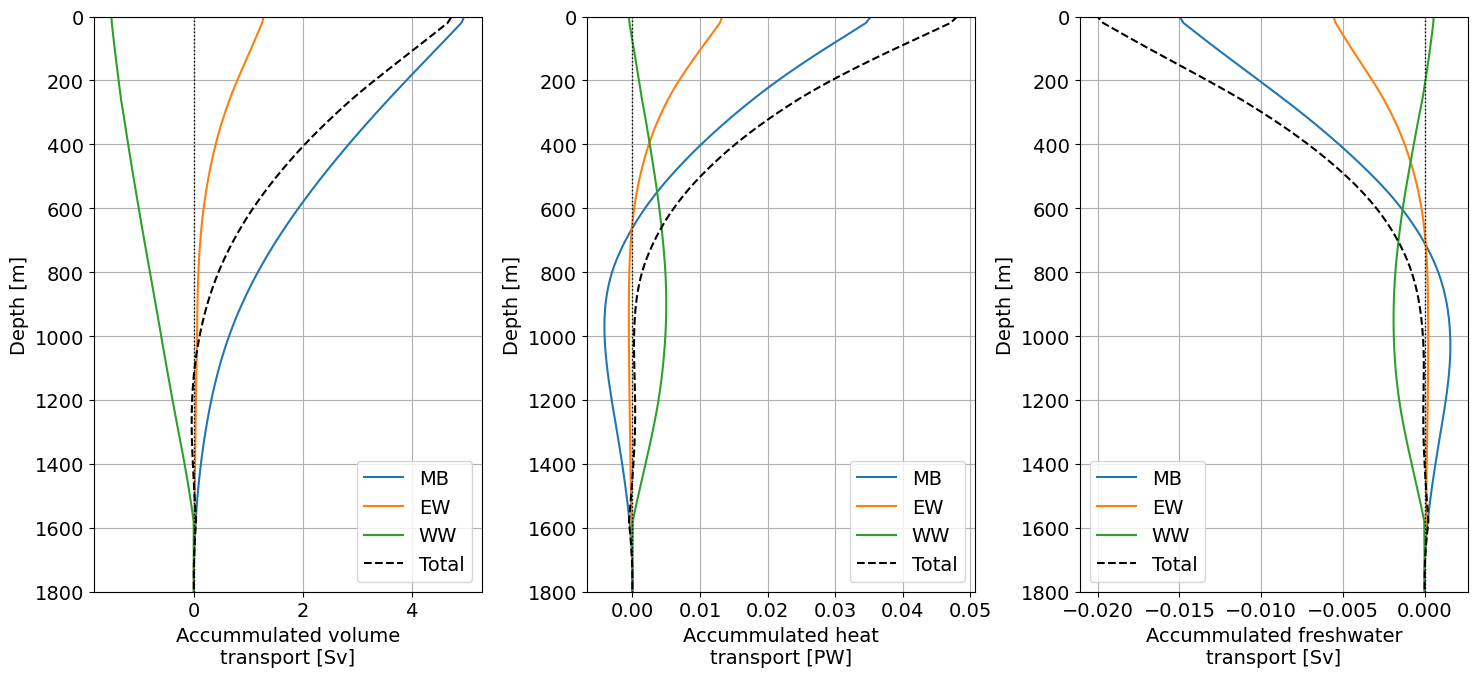

In [70]:
fig,axs = plt.subplots(1,3,figsize=[15,7])
ax=axs[0]
(ds_q_RTMB.q.sum('lon')/1e6).mean(['time']).reindex(depth=ds_q_RTMB.depth[::-1]).cumsum('depth').plot(y='depth',ylim=[1800,0],label='MB',ax=ax)
(ds_q_RTEW.q.sum('lon')/1e6).mean(['time']).reindex(depth=ds_q_RTEW.depth[::-1]).cumsum('depth').plot(y='depth',label='EW',ax=ax)
(ds_q_RTWW.q.sum('lon')/1e6).mean(['time']).reindex(depth=ds_q_RTWW.depth[::-1]).cumsum('depth').plot(y='depth',label='WW',ax=ax)
(ds_q_RT.q.sum('lon')/1e6).mean(['time']).reindex(depth=ds_q_RT.depth[::-1]).cumsum('depth').plot(y='depth',label='Total',color='k',ls='--',ax=ax)
ax.set_xlabel('Accummulated volume\ntransport [Sv]')

ax=axs[1]
(qh_MB_grid.sum('lon_MB')/1e15).mean(['TIME']).reindex(depth=qh_MB_grid.depth[::-1]).cumsum('depth').plot(y='depth',ylim=[1800,0],label='MB',ax=ax)
(qh_EW.sum('lon_EW')/1e15).mean(['TIME']).reindex(depth=qh_EW.depth[::-1]).cumsum('depth').plot(y='depth',label='EW',ax=ax)
(qh_WW.sum('lon_WW')/1e15).mean(['TIME']).reindex(depth=qh_WW.depth[::-1]).cumsum('depth').plot(y='depth',label='WW',ax=ax)
total = ((qh_MB_grid.sum('lon_MB')+qh_WW.sum('lon_WW')+(qh_EW.sum('lon_EW')))/1e15)
total.mean(['TIME']).reindex(depth=total.depth[::-1]).cumsum('depth').plot(y='depth',label='Total',color='k',ls='--',ax=ax)
ax.set_xlabel('Accummulated heat\ntransport [PW]')

ax=axs[2]
(qf_MB_grid.sum('lon_MB')/1e6).mean(['TIME']).reindex(depth=qf_MB_grid.depth[::-1]).cumsum('depth').plot(y='depth',ylim=[1800,0],label='MB',ax=ax)
(qf_EW.sum('lon_EW')/1e6).mean(['TIME']).reindex(depth=qf_EW.depth[::-1]).cumsum('depth').plot(y='depth',label='EW',ax=ax)
(qf_WW.sum('lon_WW')/1e6).mean(['TIME']).reindex(depth=qf_WW.depth[::-1]).cumsum('depth').plot(y='depth',label='WW',ax=ax)
total = ((qf_MB_grid.sum('lon_MB')+qf_WW.sum('lon_WW')+(qf_EW.sum('lon_EW')))/1e6)
total.mean(['TIME']).reindex(depth=total.depth[::-1]).cumsum('depth').plot(y='depth',label='Total',color='k',ls='--',ax=ax)
ax.set_xlabel('Accummulated freshwater\ntransport [Sv]')


for ax in axs:
    ax.axvline(0,ls=':',color='k',lw='1')
    ax.legend()
    ax.set_ylabel('Depth [m]')
    ax.grid()
    ax.set_title('')
plt.tight_layout()

fig.savefig(f'{fig_out_path}Rockall_Trough_depth_accumulated_mean_transports_{date_str_start}_{date_str_end}_{fn_version}.png',dpi=300,bbox_inches='tight')